# Introduction

This package provides functions to perform least-squares fits of quasinormal modes to ringdown waveforms. As long as you have a timeseries (either a single array or a dictionary of spherical-harmonic modes) you can use the functions provided by this package to perform fits.

In addition, some waveform classes are provided for convenience. These provide flux calculations and frame transformations which can be useful when doing ringdown analyses. Currently, there are three types of waveform class which the user can initialise:

 - **SXS**: Loads a waveform from the SXS catalog. This makes use of the `sxs` Python package to automatically download the simulation, so that you only need to specify the ID. 

 - **Surrogate**: Initializes a waveform generated by a surrogate. Currently implemented are **NRSur7dq4** and **NRHybSur3dq8**.

 - **Custom**: The user provides a dictionary of modes. 

The core fitting functions are all available in the `qnmfits.py` file. The waveform classes are in the `Waveforms` folder, and each inherit functions from `Waveforms/Base.BaseClass`.

# Analysing a SXS waveform

To demonstrate the features of the code we will work with the simulation SXS:BBH:0305, but everything will apply to a generic waveform.

## Class initialization

The only required argument for an SXS waveform is a simulation ID. However, it is a good idea to also change the zero-time to something more useful. Here we use the peak of the absolute value of the (2,2) mode (see the `Simulation` docstring for other options, including the ability to transform the modes with a rotation).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from cmcrameri import cm
from kneed import KneeLocator
from scipy.signal import find_peaks
import os
from scipy.optimize import curve_fit
qnmfits.download_cook_data()

sims = []
ids = [305, 1476, 1477, 1481, 1495, 1497, 1499, 1500, 1501, 1502, 1503, 1506, 1507, 1509]#1475 1492
for id in ids:
    sims.append(qnmfits.SXS(ID=id, zero_time=(2,2)))
    
sim = sims[0]

mismatch_dir = 'figures/mismatch/'

KerrQNM_08.h5 already downloaded.
KerrQNM_09.h5 already downloaded.
Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer


c:\qnmfits-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1477v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1477v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1481v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1481v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1495v5/Lev3/metadata.json
Found the following files to load from the SXS

## Perform a single QNM fit

In the `qnmfits` package there are functions for fitting to a single timeseries or to perform multimode fits to a dictionary of modes. We start with the simple single timeseries fit:

In [2]:
qnmfits.ringdown_fit?

Signature:
qnmfits.ringdown_fit(
    times,
    data,
    modes,
    Mf,
    chif,
    t0,
    t0_method='geq',
    T=100,
)
Docstring:
Perform a least-squares fit to some data using a ringdown model.

Parameters
----------
times : array_like
    The times associated with the data to be fitted.
    
data : array_like
    The data to be fitted by the ringdown model.
    
modes : array_like
    A sequence of (l,m,n,sign) tuples to specify which QNMs to include in 
    the ringdown model. For regular (positive real part) modes use 
    sign=+1. For mirror (negative real part) modes use sign=-1. For 
    nonlinear modes, the tuple has the form 
    (l1,m1,n1,sign1,l2,m2,n2,sign2,...).
    
Mf : float
    The remnant black hole mass, which along with chif determines the QNM
    frequencies.
    
chif : float
    The magnitude of the remnant black hole spin.
    
t0 : float
    The start time of the ringdown model.
    
t0_method : str, optional
    A requested ringdown start time will in ge

In particular, note that the QNMs to fit are provided using tuples of length four: $(\ell, m, n, \pm)$. The fourth entry is either $+1$ or $-1$, and indicates the sign of the real part of the QNM frequency. In other words, $(\ell, m, n, +1)$ refers to the "regular" modes, and $(\ell, m, n, -1)$ referes to the "mirror" modes. This is different to the "prograde" and "retrograde" classification, mostly because I wanted to avoid any ambiguity regarding the $m=0$ modes.

KeyboardInterrupt: 

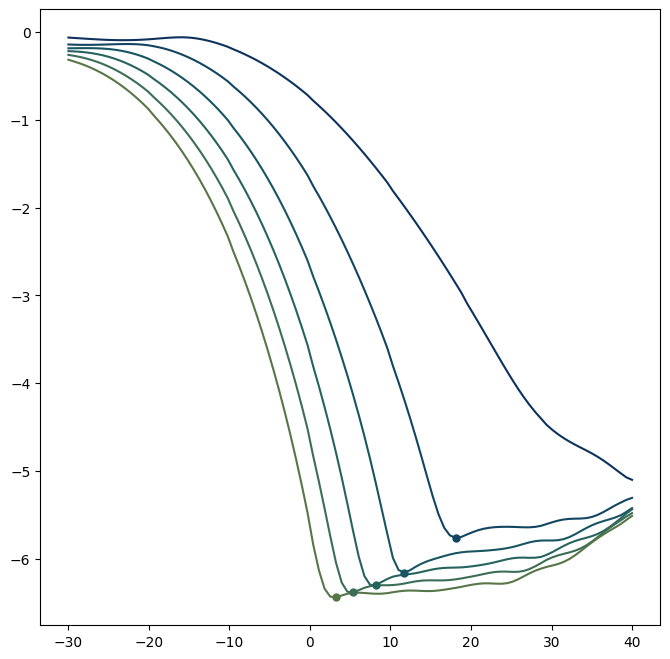

In [3]:
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))


    # The start times to use
    t0s = np.linspace(-30, 40, 100)


    N = 16
    colors = cm.batlow(np.linspace(0,1,N))

    pMs = []
    ptims = []

    for k in range(1,N):
        Ms = []
        modes = [(2,2,n,1) for n in range(k)]
        for i in range(len(t0s)):
            fit = qnmfits.ringdown_fit(
                sim.times,
                sim.h[2,2],
                modes,
                Mf=sim.Mf,
                chif=sim.chif_mag,
                t0=t0s[i]
            )
            Ms.append(fit['mismatch'])

        logMs = np.log(Ms)/np.log(10)
        
        ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
        
        peak, _ = find_peaks(-logMs, height=3, prominence=1e-10)
        #print(peak)

        p = [t0s[peak],logMs[peak]]
        if len(peak) >= 1:
            ax.plot(t0s[peak[0]], logMs[peak[0]], "o", markersize = 5, color = colors[k], zorder=100)
            ptims.append(t0s[peak[0]])
            pMs.append(logMs[peak[0]])
        #print("Peak is at " + str(p))


    #ax.grid(which='both')
    ax.set_title(r'Mismatch for no. of modes fitted with peaks (scipy) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    ax.set_ylabel('$\mathcal{M}$')
    ax.legend(loc='lower right')
    #ax.set_yscale('log')

    #ax.set_xlim(-3,0)
    #ax.set_ylim(-7,-6)


    _ = ax.legend(ncol=2, frameon=False, fontsize=7)
    #plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    #if not os.path.exists(mismatch_dir):
    #    os.makedirs(mismatch_dir)
    #plt.savefig(mismatch_dir + 'mismatchpeaksscipy' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    #print('Saved mismatchpeaksscipy' + f'{ind:04}' + '.png')

[-2035.74117798 -2035.0685529  -2034.40494177 ...   157.08110682
   157.18110446   157.28110211]
[0.67262508 0.66361113 0.66536457 ... 0.09999764 0.09999764 0.09999765]


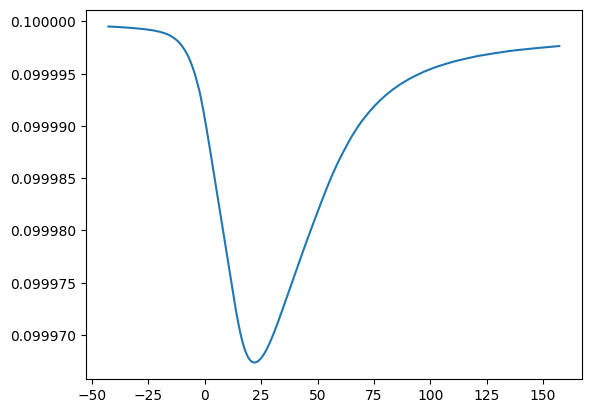

In [ ]:
print(sim.times)
print(np.diff(sim.times))

k = 2000
plt.plot(sim.times[:-1][-k:],np.diff(sim.times)[-k:])


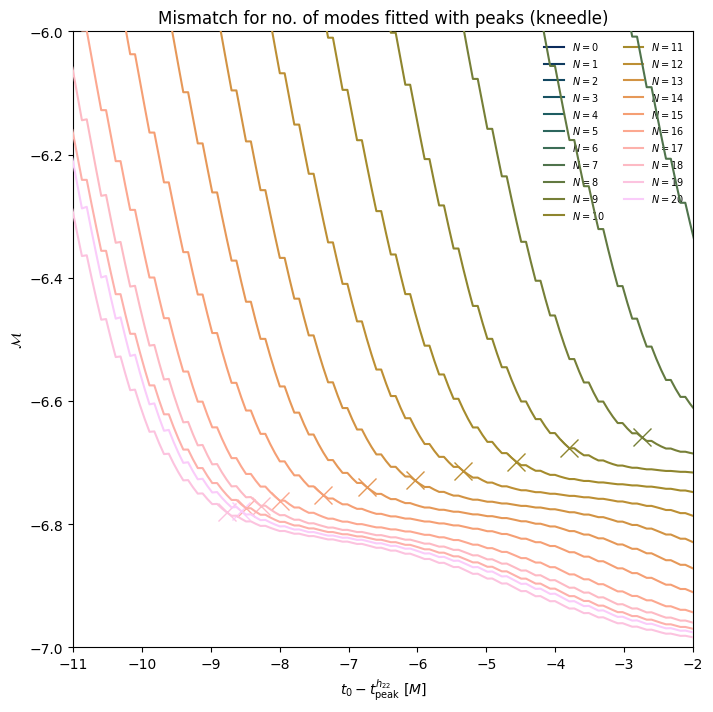

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 1000)


N = 22
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log10(Ms)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    kneedle = KneeLocator(t0s, logMs, S=10, curve="convex", direction="decreasing", online = "true")
    ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k])
    #print((kneedle.knee))
    #print((kneedle.elbow))
    pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
    ptims.append(kneedle.knee)


#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
ax.legend(loc='lower right')
#ax.set_yscale('log')

ax.set_xlim(-11,-2)
ax.set_ylim(-7,-6)


_ = ax.legend(ncol=2, frameon=False, fontsize=7)
plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

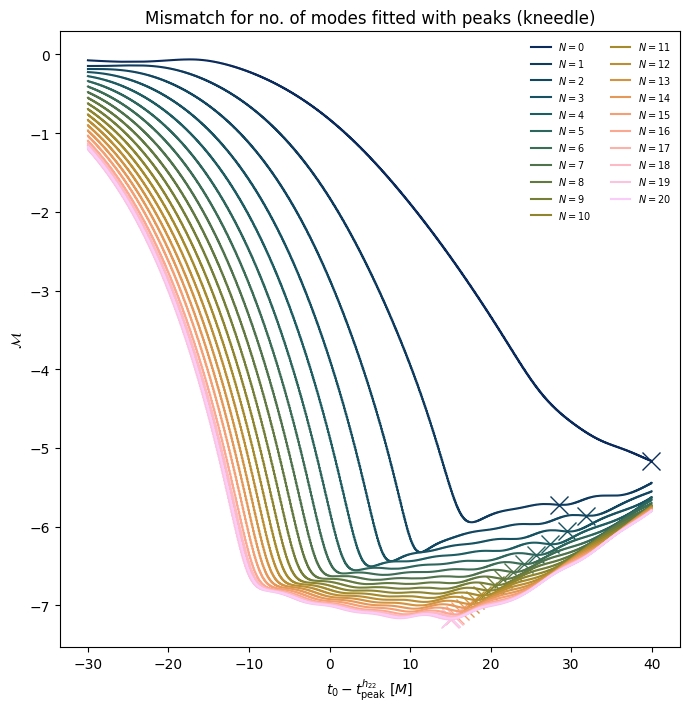

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 10000)


N = 22
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log10(Ms)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    kneedle = KneeLocator(t0s, logMs, S=10, curve="convex", direction="decreasing", online = "true")
    ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k])
    #print((kneedle.knee))
    #print((kneedle.elbow))
    pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
    ptims.append(kneedle.knee)


#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
ax.legend(loc='lower right')
#ax.set_yscale('log')

#ax.set_xlim(-11,-2)
#ax.set_ylim(-7,-6)


_ = ax.legend(ncol=2, frameon=False, fontsize=7)
plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

[15.098509850985096, 15.3995399539954, 14.9024902490249, 15.098509850985096]

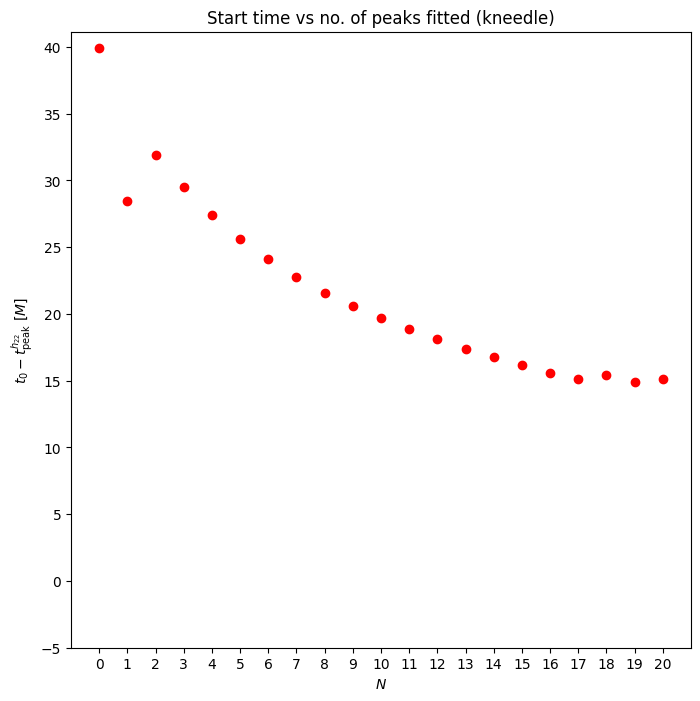

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

Nmodes = np.arange(N-1)

ax.scatter(Nmodes,ptims,color="red")

#ax.grid(which='both')
ax.set_title(r'Start time vs no. of peaks fitted (kneedle)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,40,10));
ax.set_xticks(Nmodes);

#plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')

ptims[-4:]

Saved mismatchpeakskneedle0305.png
Saved mismatchstarttimescipy0305.png
Saved mismatchpeakskneedlelast0305.png


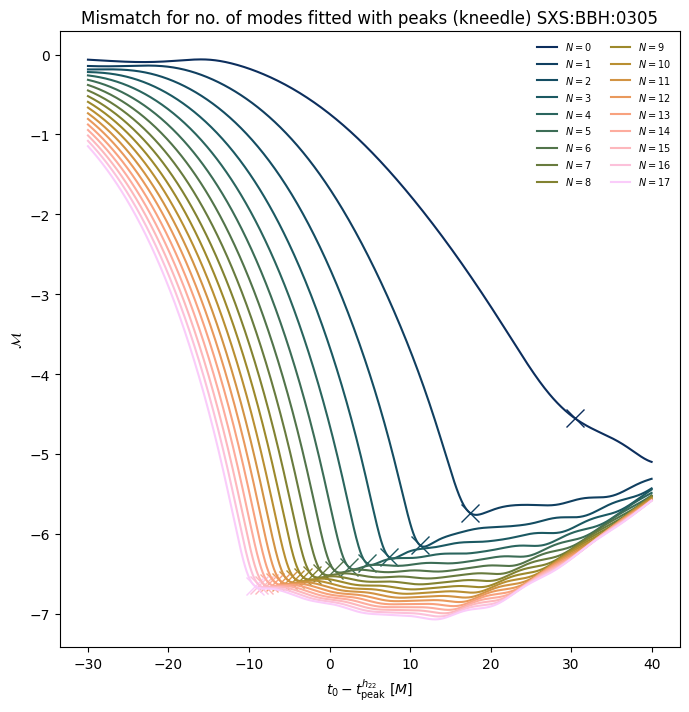

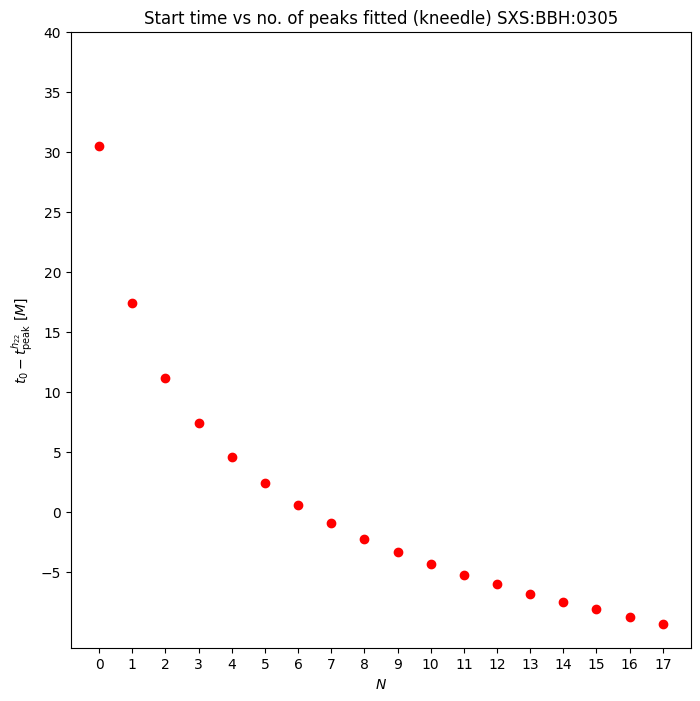

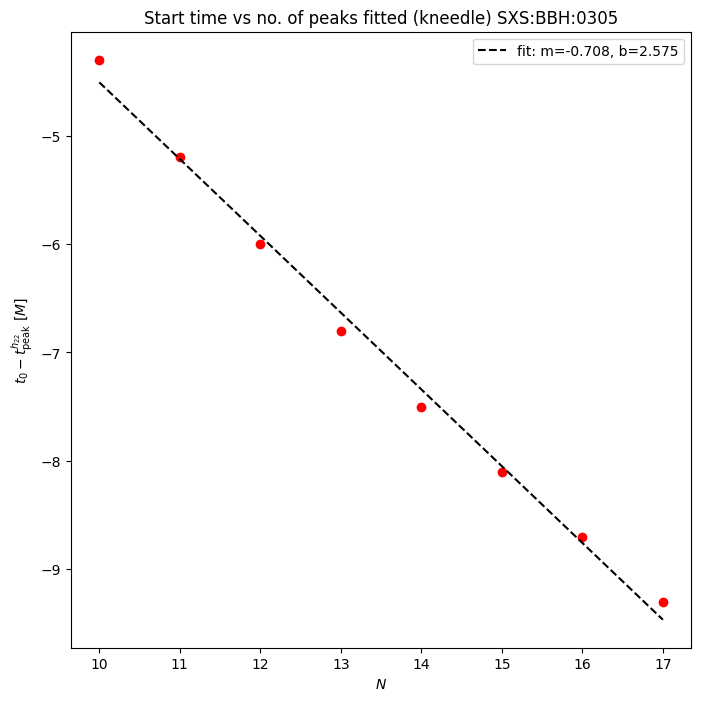

: 

In [8]:
comb = []
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))


    # The start times to use
    #t0s = np.linspace(-30, 40, 1000)


    t0s = sim.times[np.logical_and(sim.times > -30, sim.times < 40)]


    N = 19
    colors = cm.batlow(np.linspace(0,1,N))

    pMs = []
    ptims = []

    for k in range(1,N):
        Ms = []
        modes = [(2,2,n,1) for n in range(k)]
        for i in range(len(t0s)):
            fit = qnmfits.ringdown_fit(
                sim.times,
                sim.h[2,2],
                modes,
                Mf=sim.Mf,
                chif=sim.chif_mag,
                t0=t0s[i],
                t0_method = 'closest'
            )
            Ms.append(fit['mismatch'])

        logMs = np.log(Ms)/np.log(10)
        
        ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
        
        kneedle = KneeLocator(t0s, logMs, S=0.001, curve="convex", direction="decreasing", online = "true")
        ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k])
        #print((kneedle.knee))
        #print((kneedle.elbow))
        pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
        ptims.append(kneedle.knee)

        #print(np.diff(t0s))


    #ax.grid(which='both')
    ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    ax.set_ylabel('$\mathcal{M}$')
    ax.legend(loc='lower right')
    #ax.set_yscale('log')

    #ax.set_xlim(-11,-8)
    #ax.set_ylim(-7,-6)

    _ = ax.legend(ncol=2, frameon=False, fontsize=7)
    #plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    if not os.path.exists(mismatch_dir):
        os.makedirs(mismatch_dir)
    plt.savefig(mismatch_dir + 'mismatchpeakskneedle' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    print('Saved mismatchpeakskneedle' + f'{ind:04}' + '.png')

################################################################################
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.scatter(np.arange(N-1),ptims,color="red")

    #ax.grid(which='both')
    ax.set_title(r'Start time vs no. of peaks fitted (kneedle) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_yscale('log')

    ax.set_yticks(np.linspace(-5,40,10));
    ax.set_xticks(np.arange(N-1));

    #plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    if not os.path.exists(mismatch_dir):
        os.makedirs(mismatch_dir)
    plt.savefig(mismatch_dir + 'mismatchstarttimescipy' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    print('Saved mismatchstarttimescipy' + f'{ind:04}' + '.png')

    # for combined plot
    comb.append(ptims)
    
    
################################################################################

    fig, ax = plt.subplots(figsize=(8,8))

    lastN = np.arange(N-1)[-8:]
    lastt = np.array(ptims[-8:])

    ax.scatter(lastN, lastt, color="red")


    # Defining the function we want to fit.
    def modelfunc(x, m, b):
        return m*x + b

    # Extracting parameters from the fit.
    popt, pcov = curve_fit(modelfunc, lastN, lastt)

    ax.plot(lastN, modelfunc(lastN, *popt), 'black', linestyle='--', label='fit: m=%5.3f, b=%5.3f' % tuple(popt), zorder=10)


    #ax.grid(which='both')
    ax.set_title(r'Start time vs no. of peaks fitted (kneedle) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_yscale('log')
    ax.legend(loc='upper right')

    #ax.set_yticks(np.aarange)
    ax.set_xticks(np.arange(N-1)[-8:]);

    #plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    if not os.path.exists(mismatch_dir):
        os.makedirs(mismatch_dir)
    plt.savefig(mismatch_dir + 'mismatchpeakskneedlelast' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    print('Saved mismatchpeakskneedlelast' + f'{ind:04}' + '.png')


################################################################################



Saved combinedstartimevspeaks.png


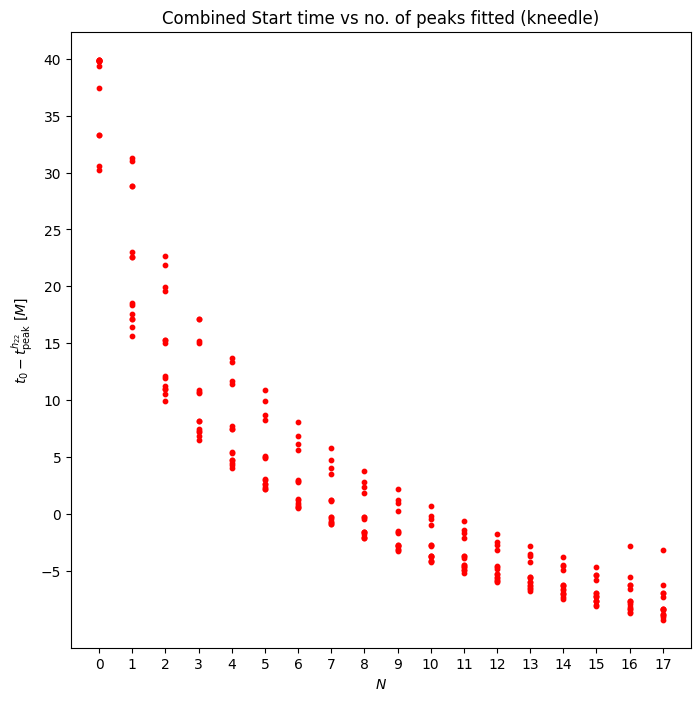

In [ ]:
y = np.array(comb).T.flatten()

n,m = np.array(comb).shape
x = np.array([[x]*n for x in range(m)]).flatten()

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(x,y,s=10,color="red")

#ax.grid(which='both')
ax.set_title(r'Combined Start time vs no. of peaks fitted (kneedle)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,40,10));
ax.set_xticks(np.arange(N-1));

if not os.path.exists(mismatch_dir):
    os.makedirs(mismatch_dir)
plt.savefig(mismatch_dir + 'combinedstartimevspeaks' + '.png', dpi=500, bbox_inches='tight')
print('Saved combinedstartimevspeaks' + '.png')


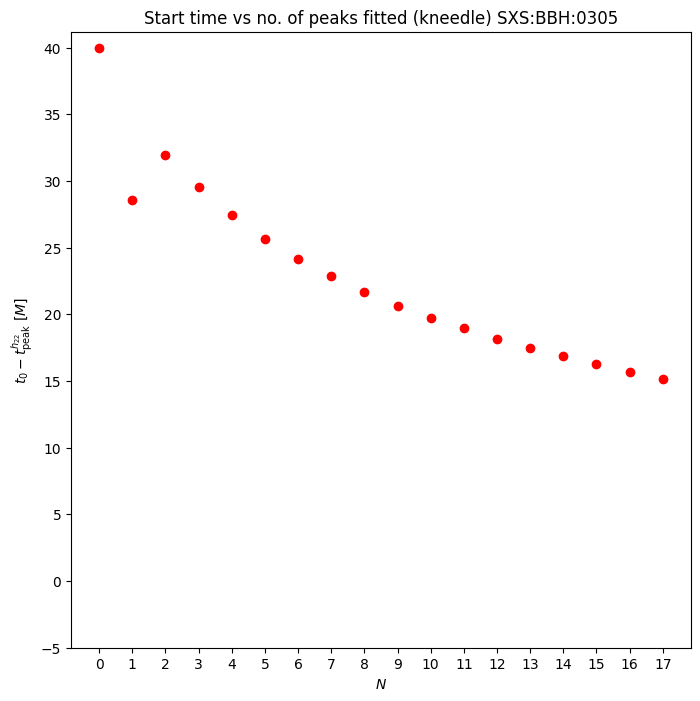

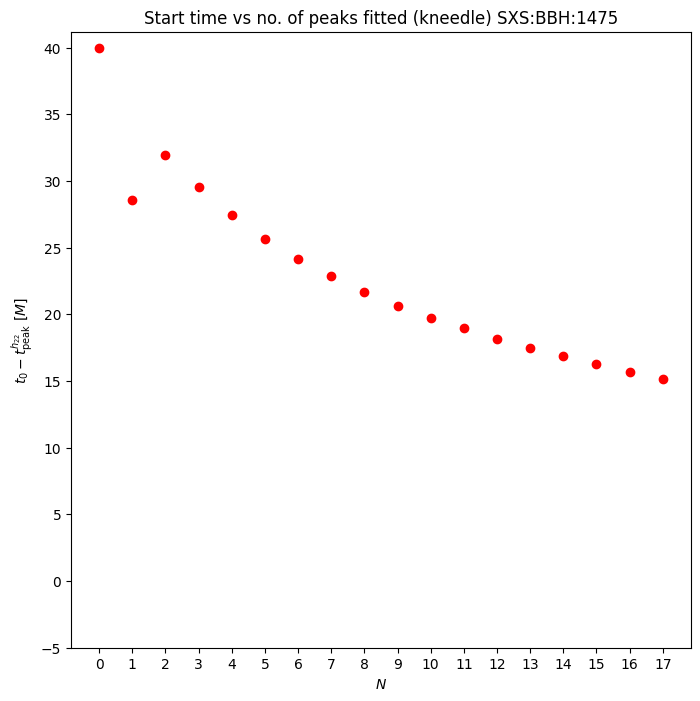

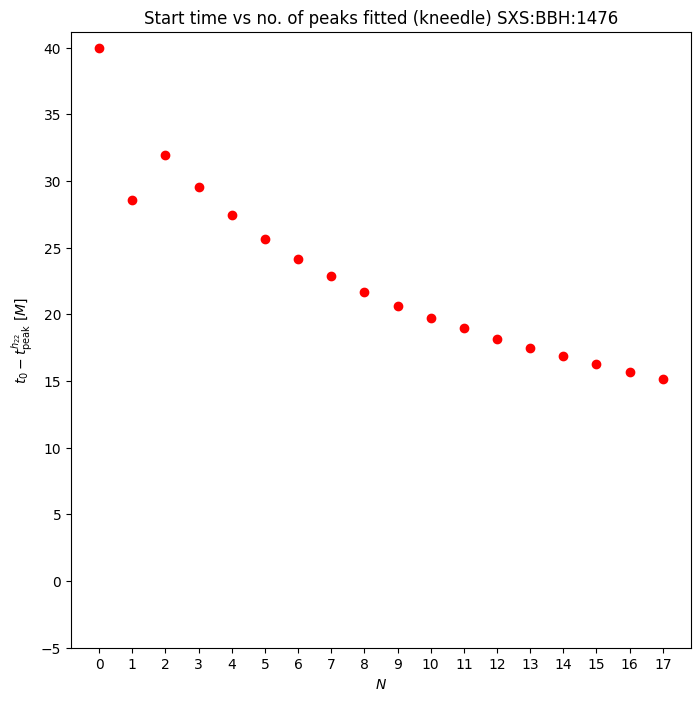

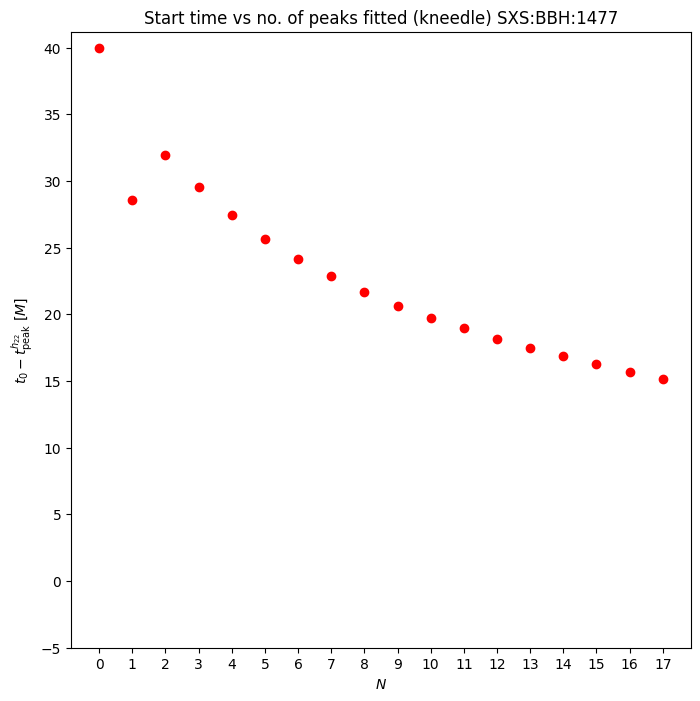

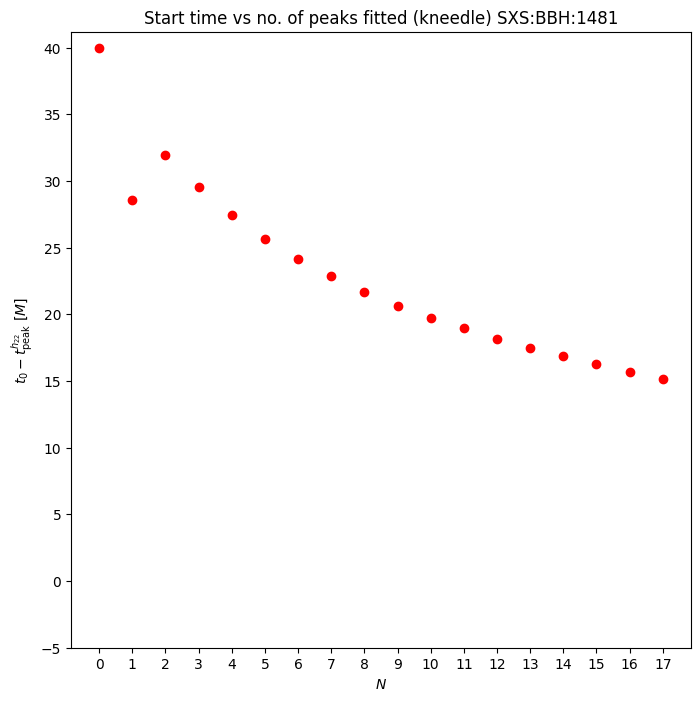

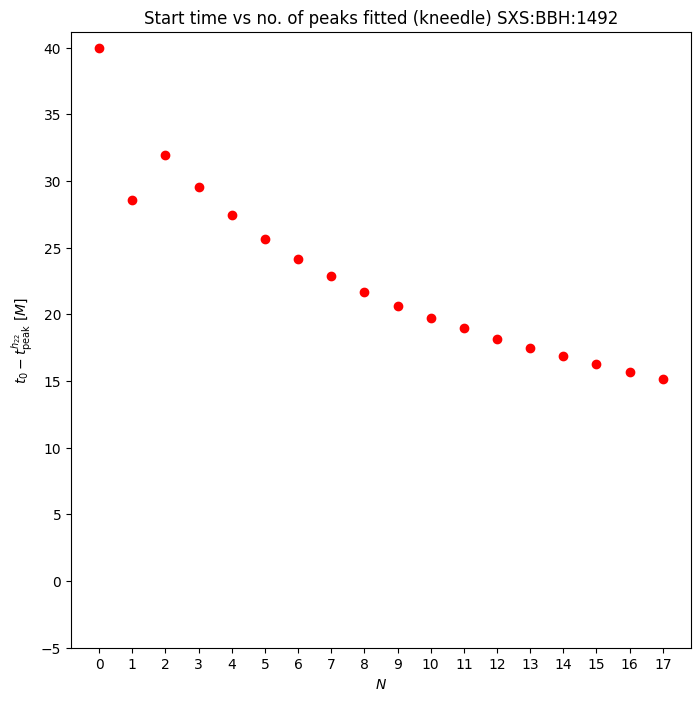

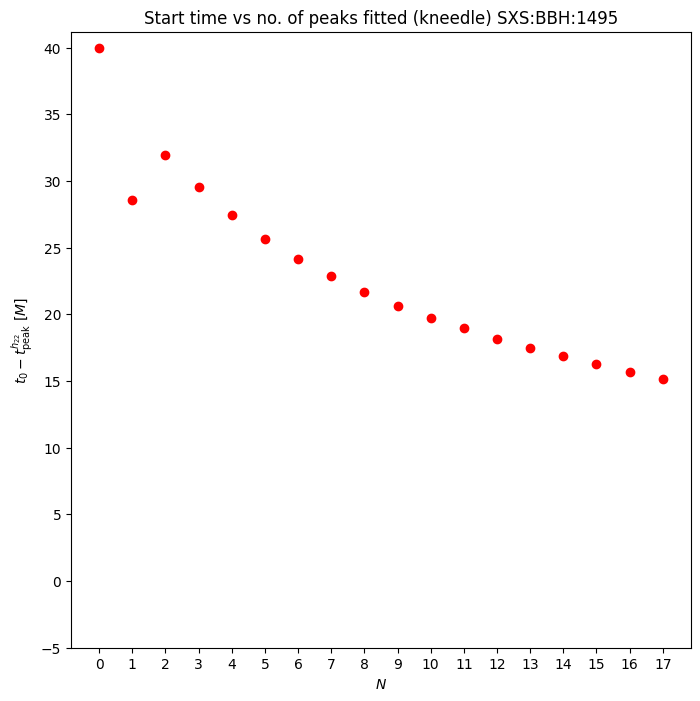

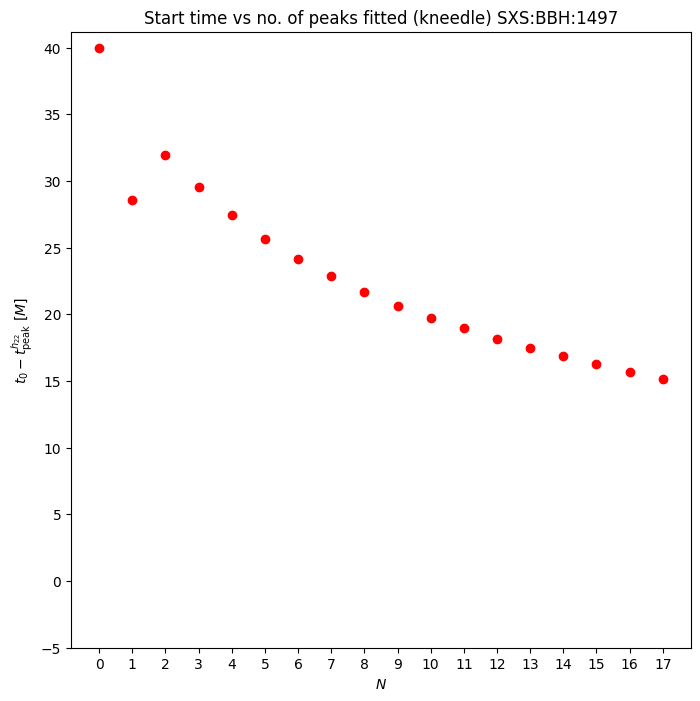

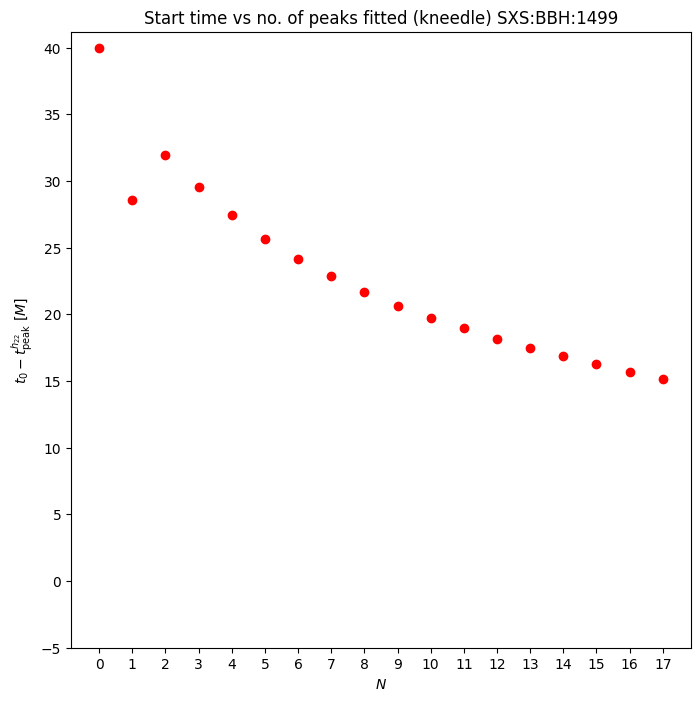

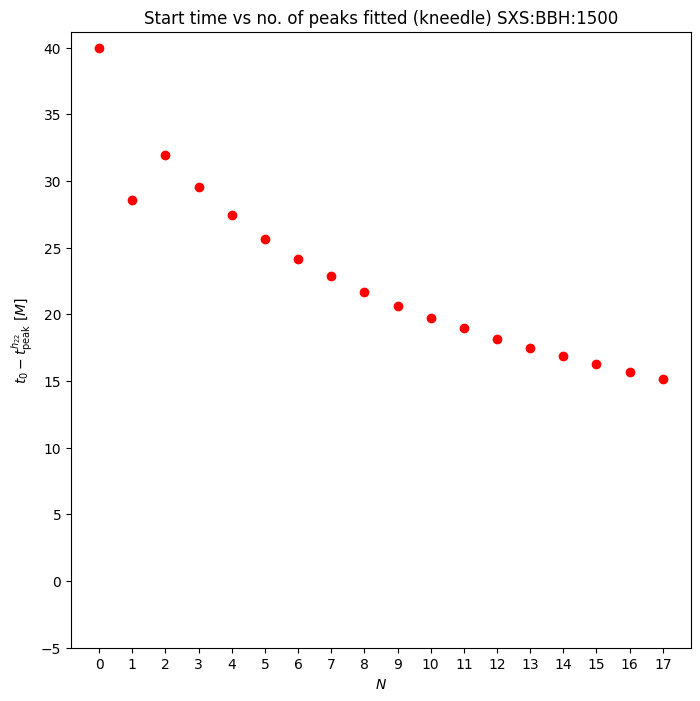

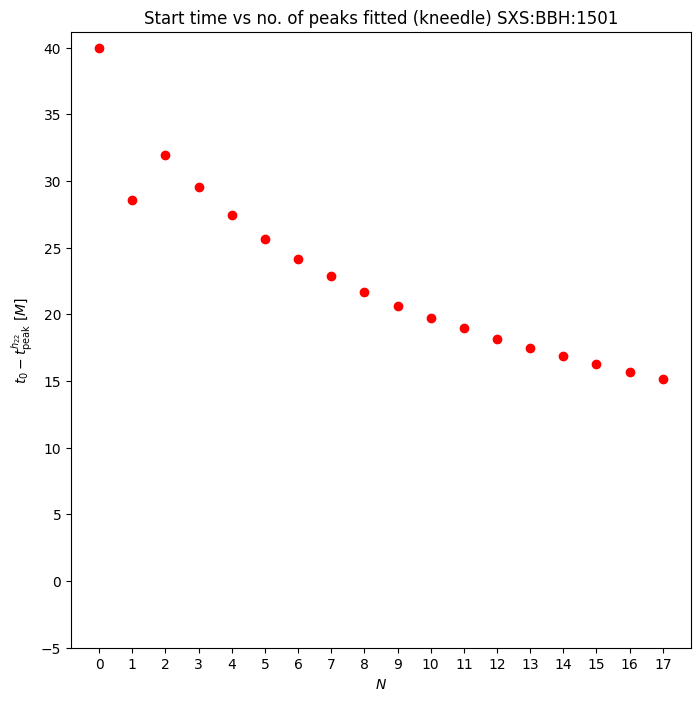

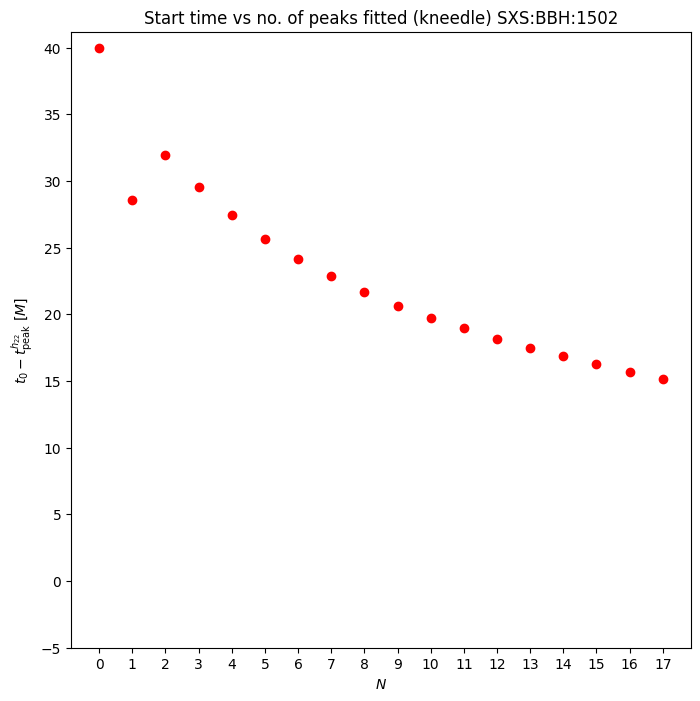

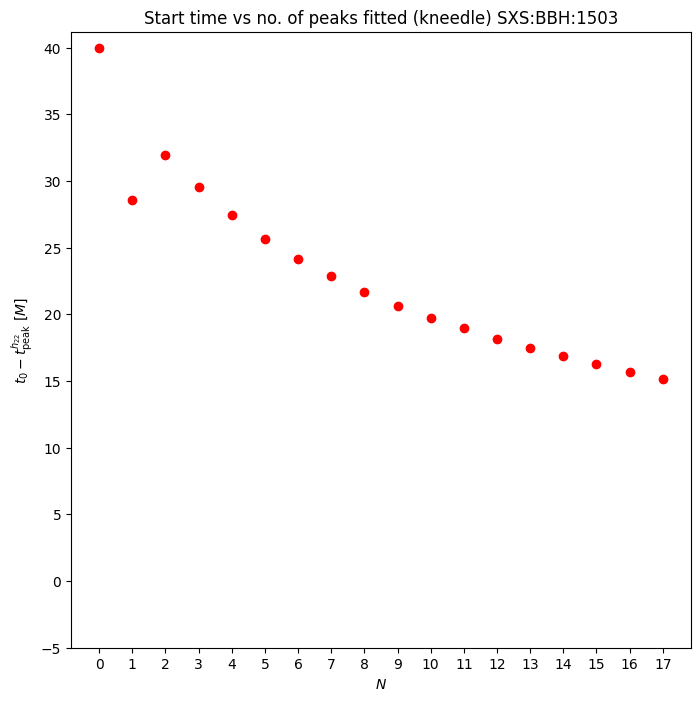

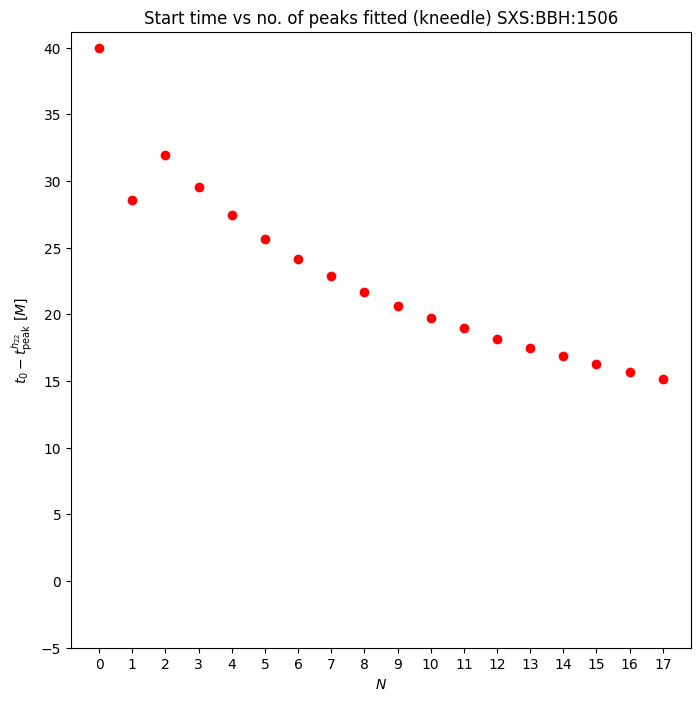

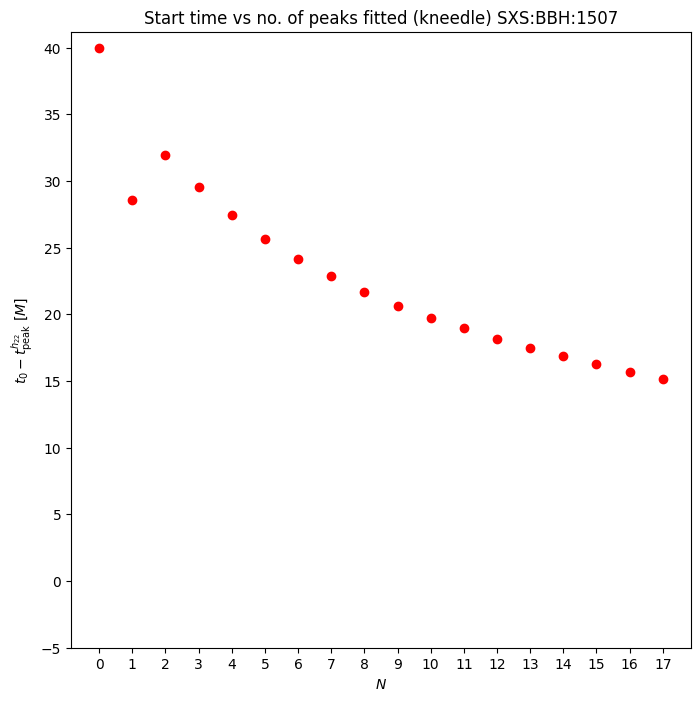

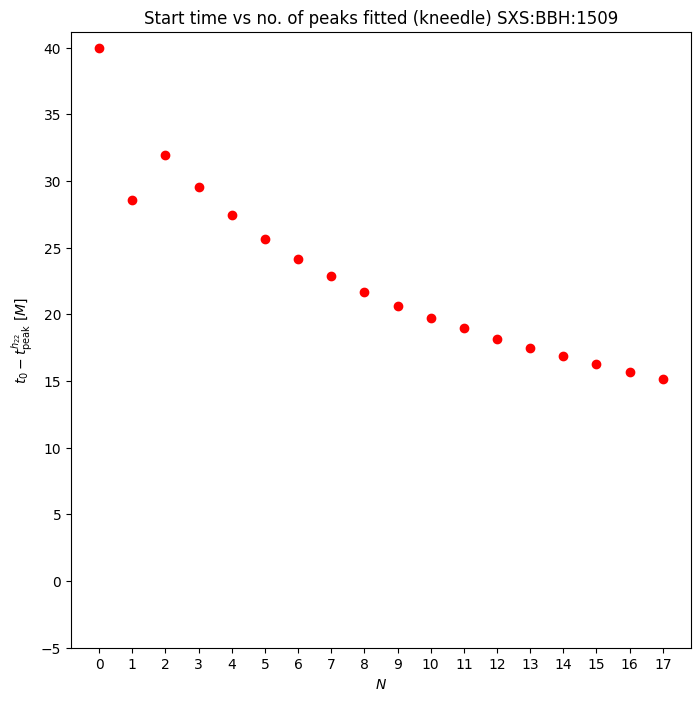

In [ ]:
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.scatter(np.arange(N-1),ptims,color="red")

    #ax.grid(which='both')
    ax.set_title(r'Start time vs no. of peaks fitted (kneedle) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_yscale('log')

    ax.set_yticks(np.linspace(-5,40,10));
    ax.set_xticks(np.arange(N-1));

    #plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    #if not os.path.exists(mismatch_dir):
    #    os.makedirs(mismatch_dir)
    #plt.savefig(mismatch_dir + 'mismatchstarttimescipy' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    #print('Saved mismatchstarttimescipy' + f'{ind:04}' + '.png')

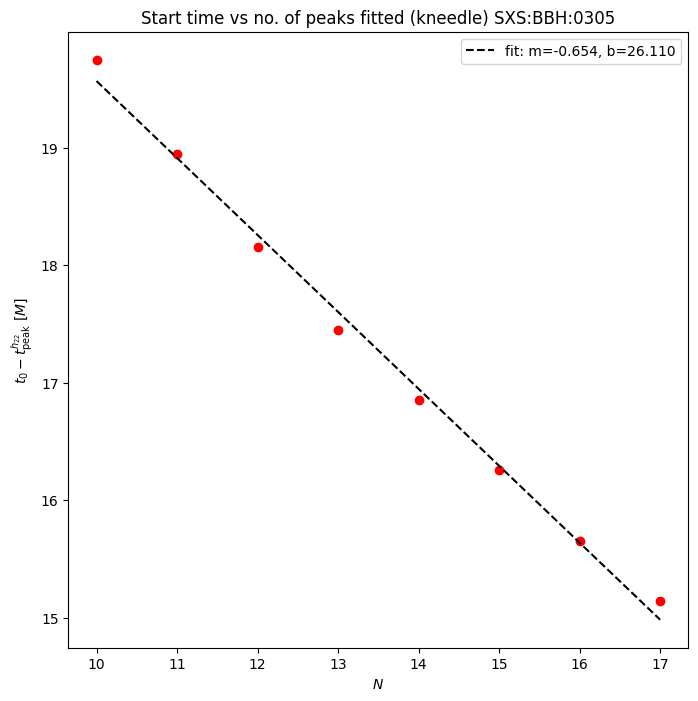

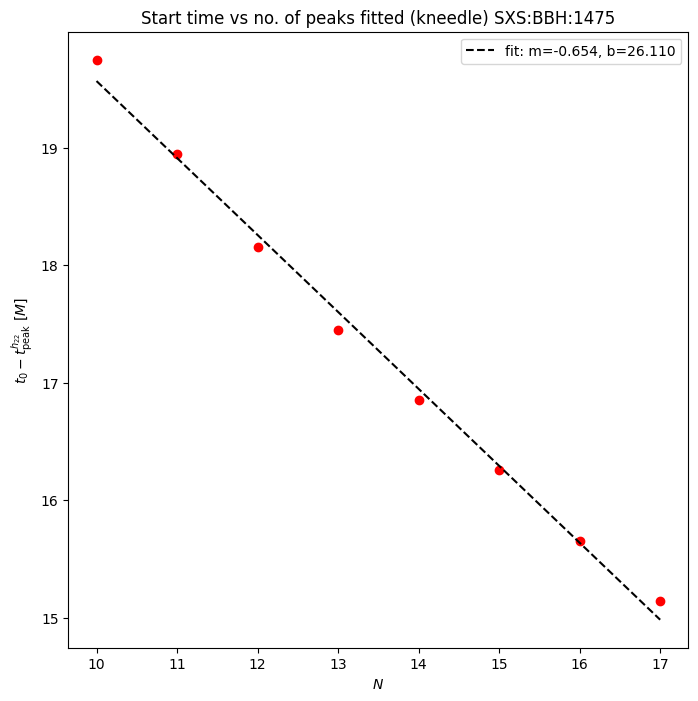

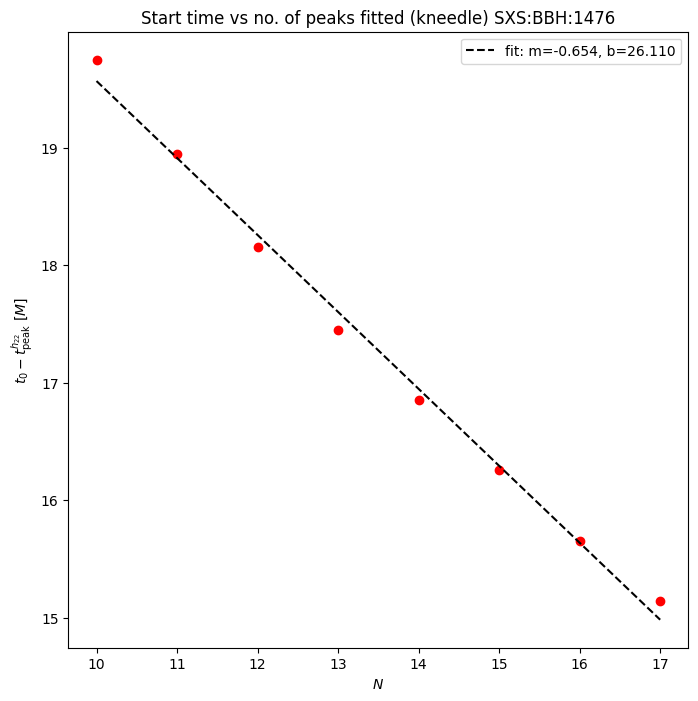

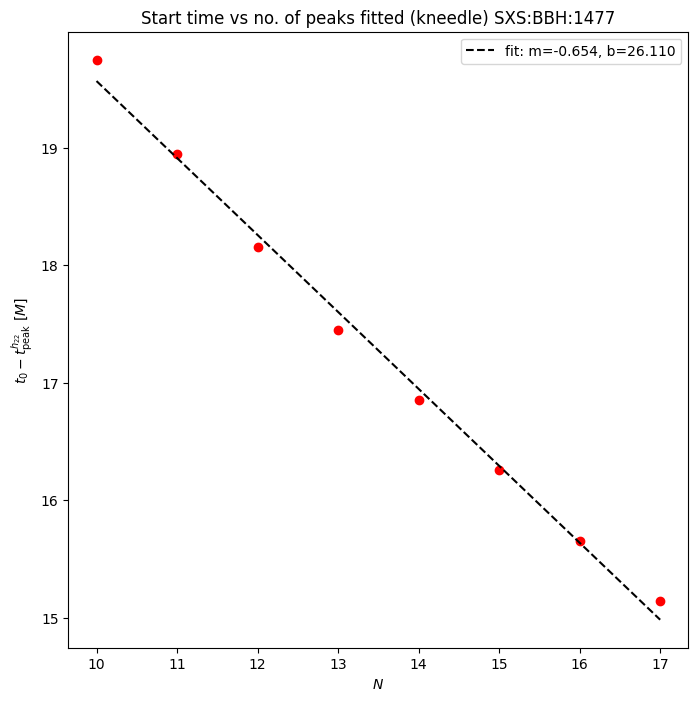

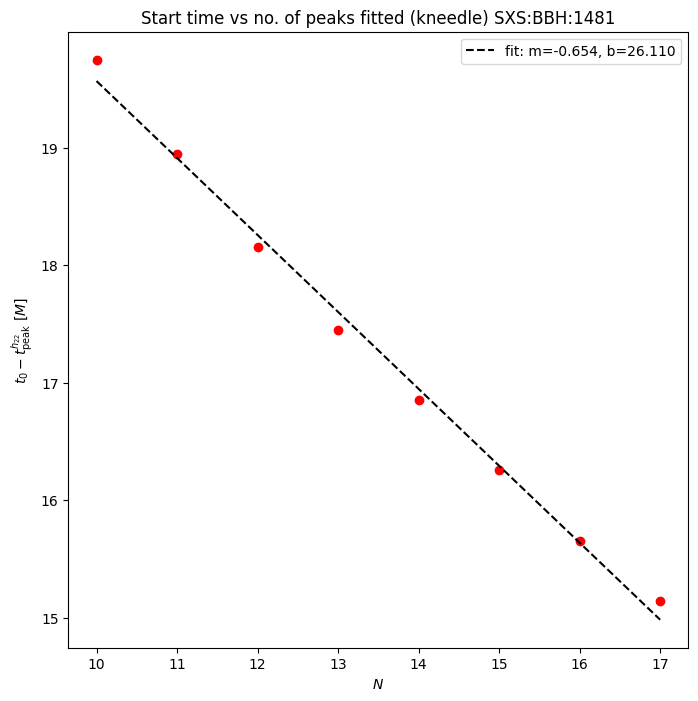

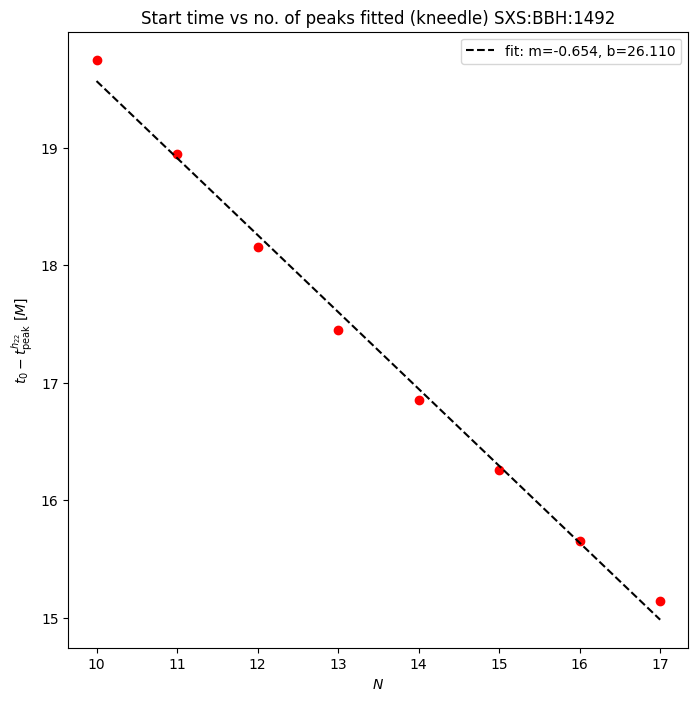

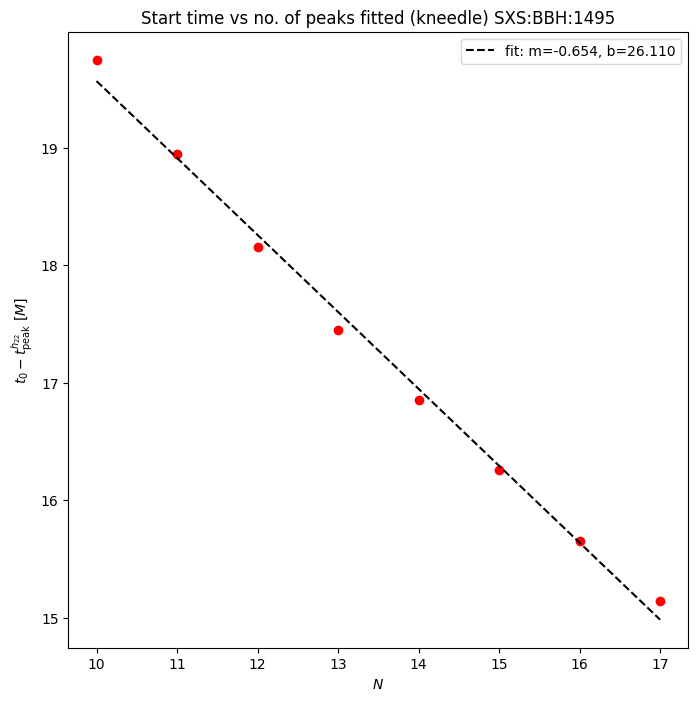

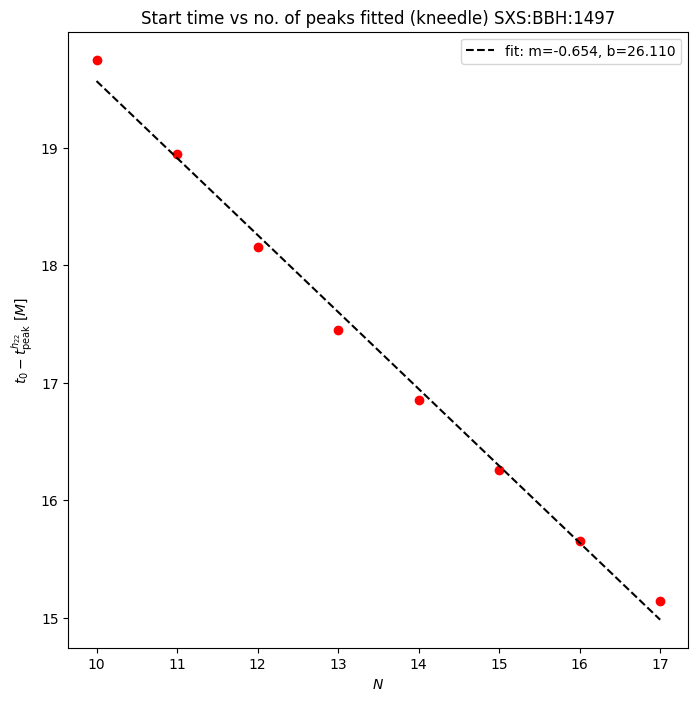

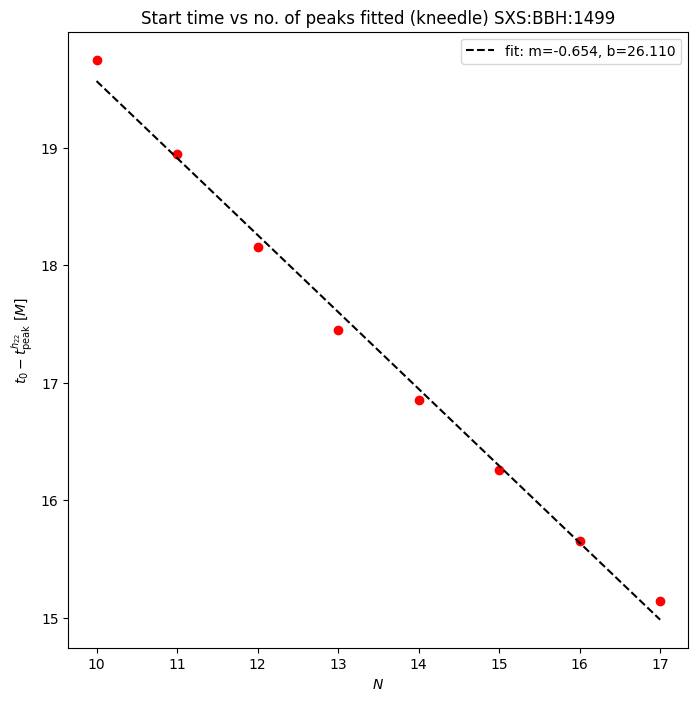

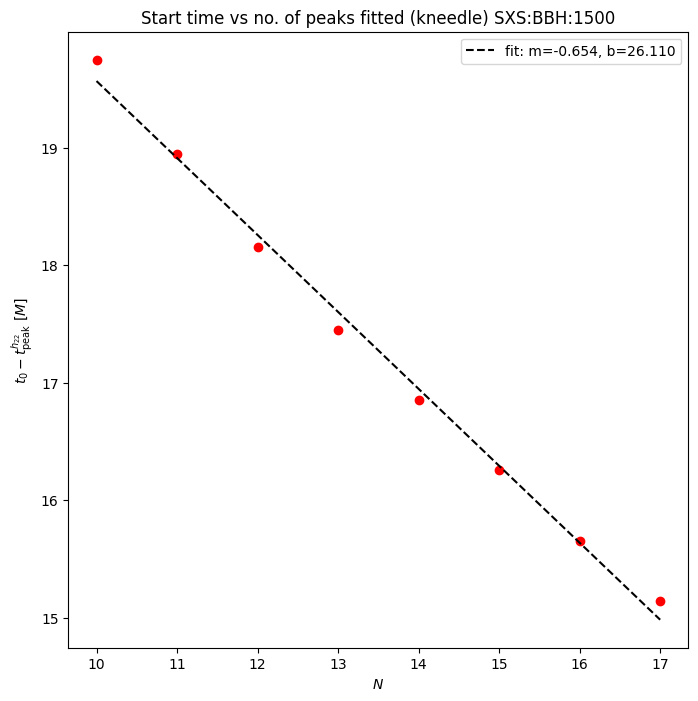

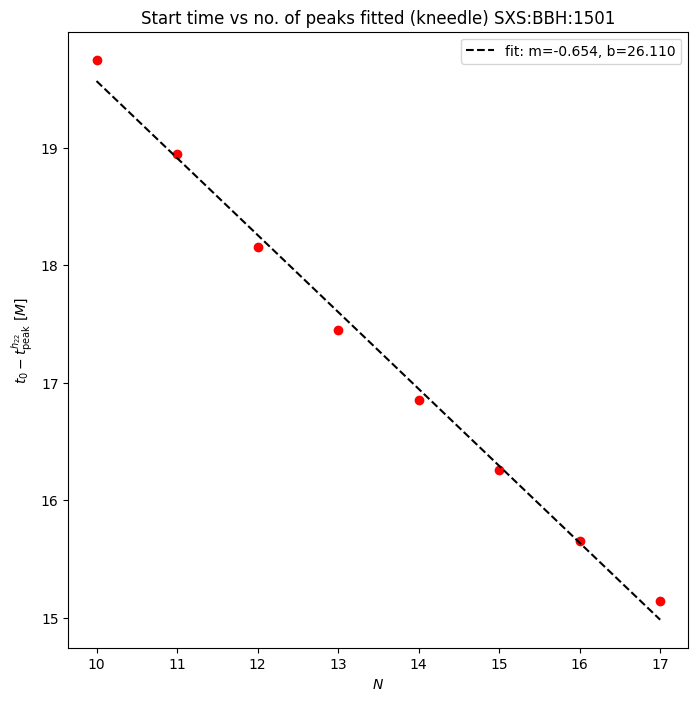

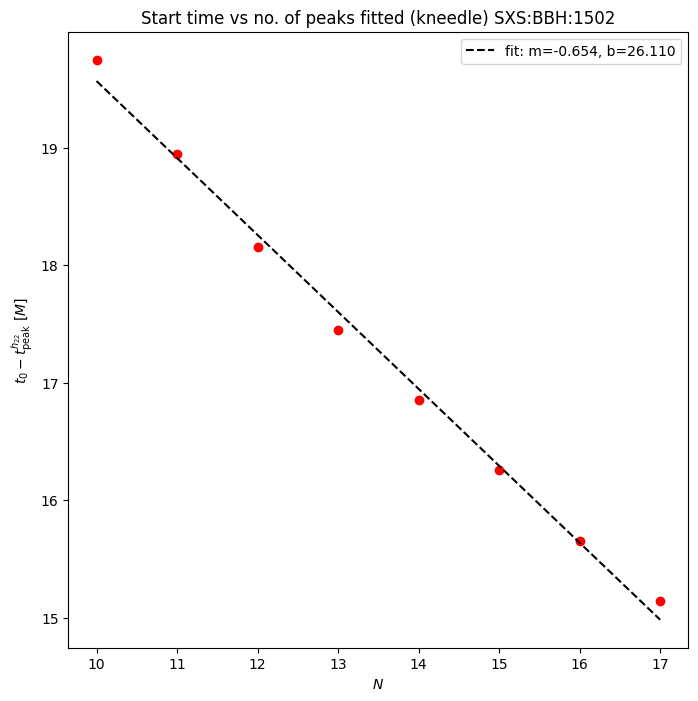

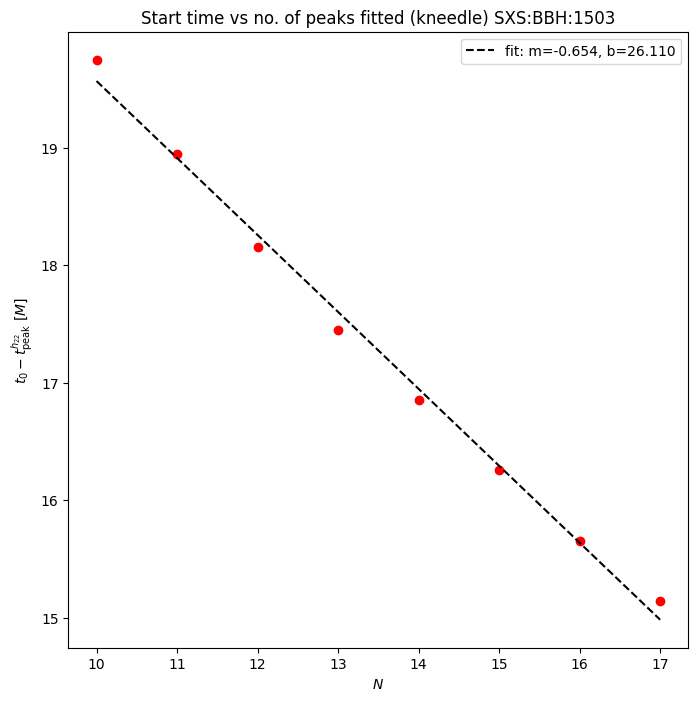

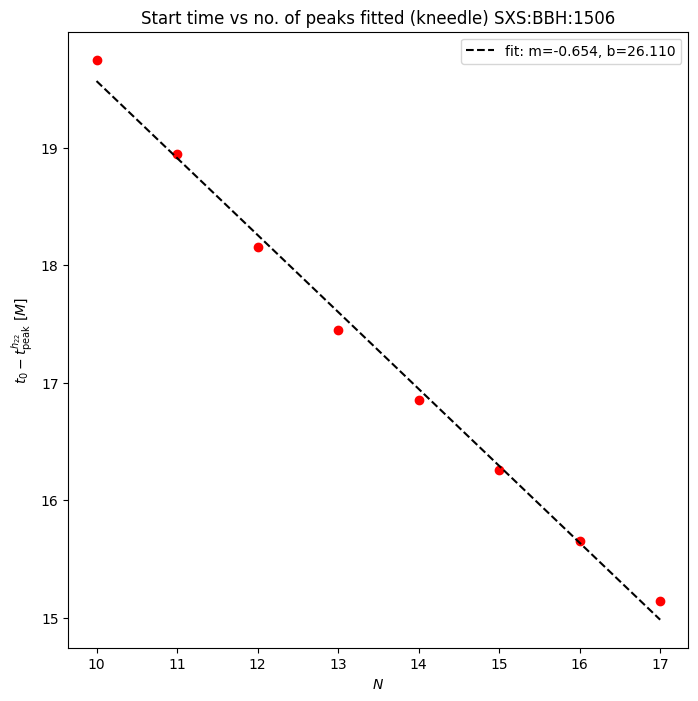

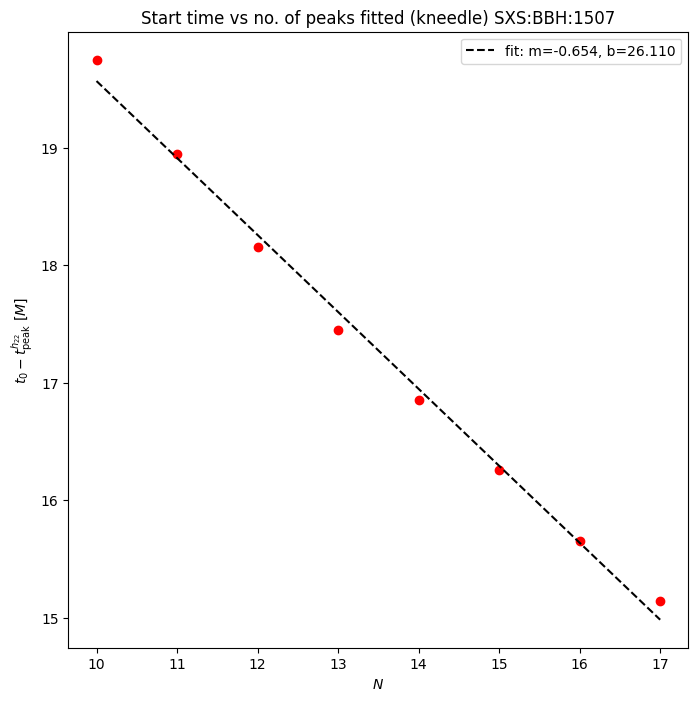

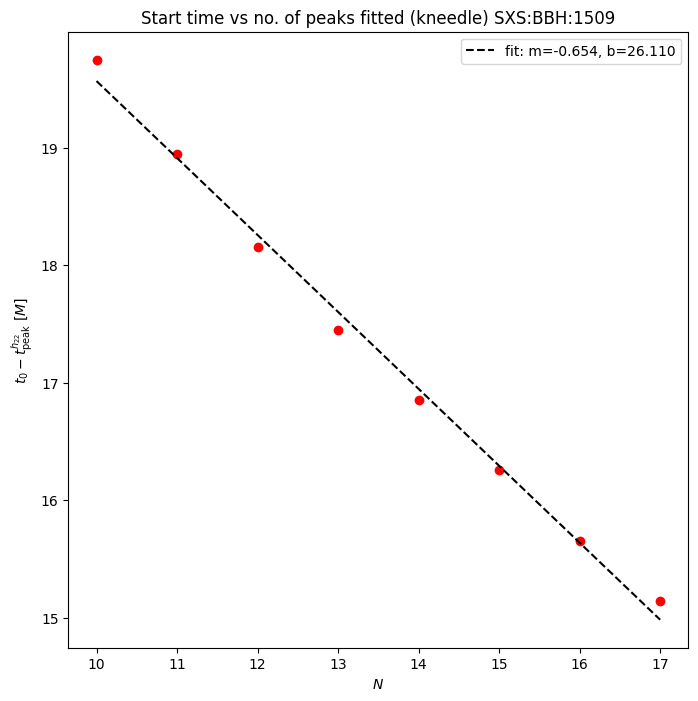

In [ ]:
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))

    lastN = np.arange(N-1)[-8:]
    lastt = np.array(ptims[-8:])

    ax.scatter(lastN, lastt, color="red")


    # Defining the function we want to fit.
    def modelfunc(x, m, b):
        return m*x + b

    # Extracting parameters from the fit.
    popt, pcov = curve_fit(modelfunc, lastN, lastt)

    ax.plot(lastN, modelfunc(lastN, *popt), 'black', linestyle='--', label='fit: m=%5.3f, b=%5.3f' % tuple(popt), zorder=10)


    #ax.grid(which='both')
    ax.set_title(r'Start time vs no. of peaks fitted (kneedle) SXS:BBH:' + f'{ind:04}')
    ax.set_xlabel('$N$')
    ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_yscale('log')
    ax.legend(loc='upper right')

    #ax.set_yticks(np.aarange)
    ax.set_xticks(np.arange(N-1)[-8:]);

    #plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    #if not os.path.exists(mismatch_dir):
    #    os.makedirs(mismatch_dir)
    #plt.savefig(mismatch_dir + 'mismatchpeakskneedlelast' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    #print('Saved mismatchpeakskneedlelast' + f'{ind:04}' + '.png')

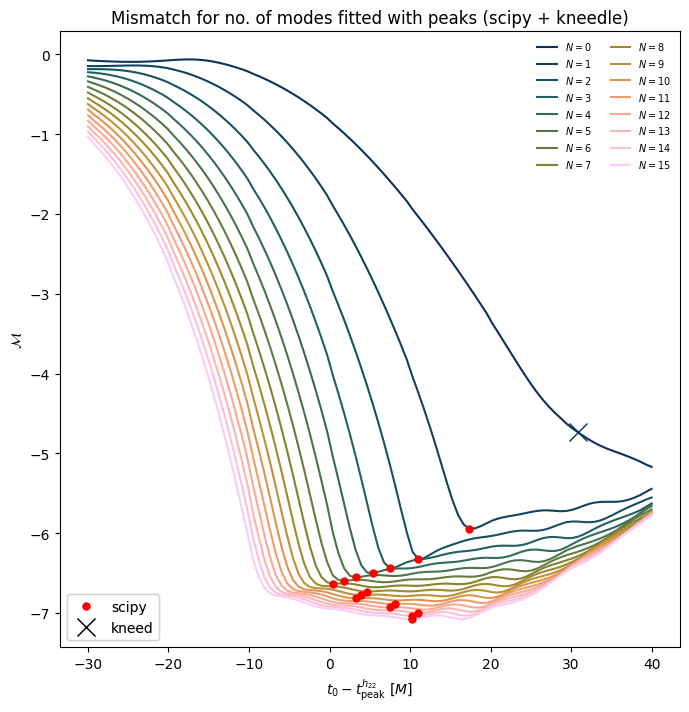

In [ ]:
from kneed import KneeLocator
from scipy.signal import find_peaks
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 100)


N = 17
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log(Ms)/np.log(10)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    peak, _ = find_peaks(-logMs, height=3, prominence=0.0000000000000000001)
    #print(peak)

    p = [t0s[peak],logMs[peak]]

    if len(peak) >= 1:
        ax.plot(t0s[peak[0]], logMs[peak[0]], "o", markersize = 5, color = "red", zorder=100)
        ptims.append(t0s[peak[0]])
        pMs.append(logMs[peak[0]])
    else:
        kneedle = KneeLocator(t0s, -logMs, S=0.01, curve="concave", direction="increasing", online = "true")
        ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k], zorder=100)
        pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
        ptims.append(kneedle.knee)



#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (scipy + kneedle)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
#ax.set_yscale('log')

legend1 = ax.legend(ncol=2, frameon=False, fontsize=7, loc='upper right')

# Add the first legend to the axis
ax.add_artist(legend1)

legend_elements = [Line2D([0], [0], marker='o', color='red', label='scipy',
                          markerfacecolor='red', markersize=5, linestyle='None'),
                   Line2D([0], [0], marker='x', color='black', label='kneed',
                          markerfacecolor='black', markersize=12.5, linestyle='None')]

# Create the first legend
legend2 = ax.legend(handles=legend_elements, loc='lower left')

# Add the first legend to the axis
ax.add_artist(legend2)


#plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

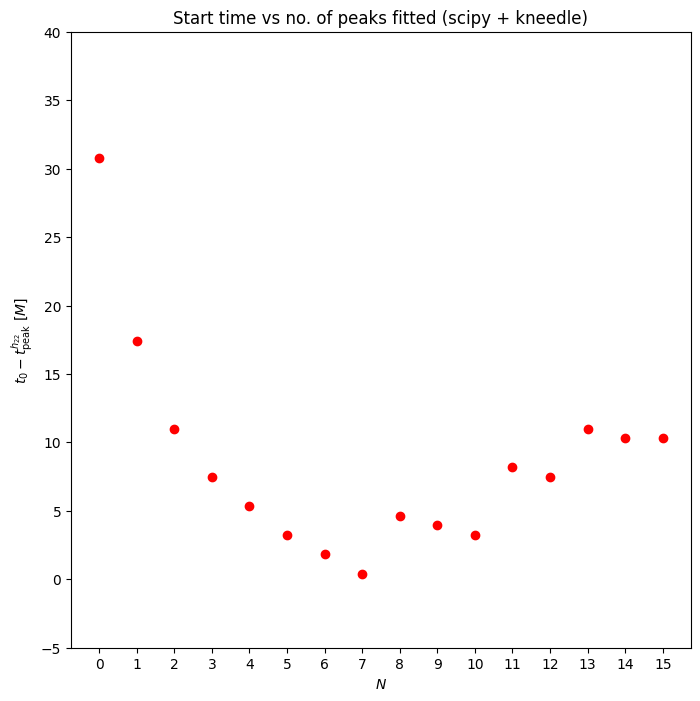

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(np.arange(N-1),np.array(ptims),color="red")

#ax.grid(which='both')
ax.set_title(r'Start time vs no. of peaks fitted (scipy + kneedle)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,40,10))
ax.set_xticks(np.arange(N-1))

#plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')

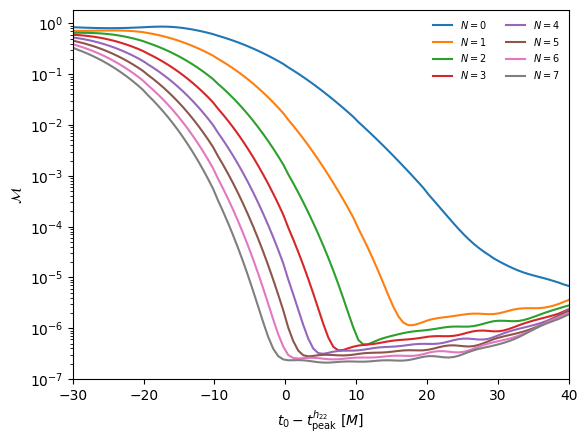

In [ ]:
# We will fit to the (2,2) spherical-harmonic mode, with the following
# combinations of modes:
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

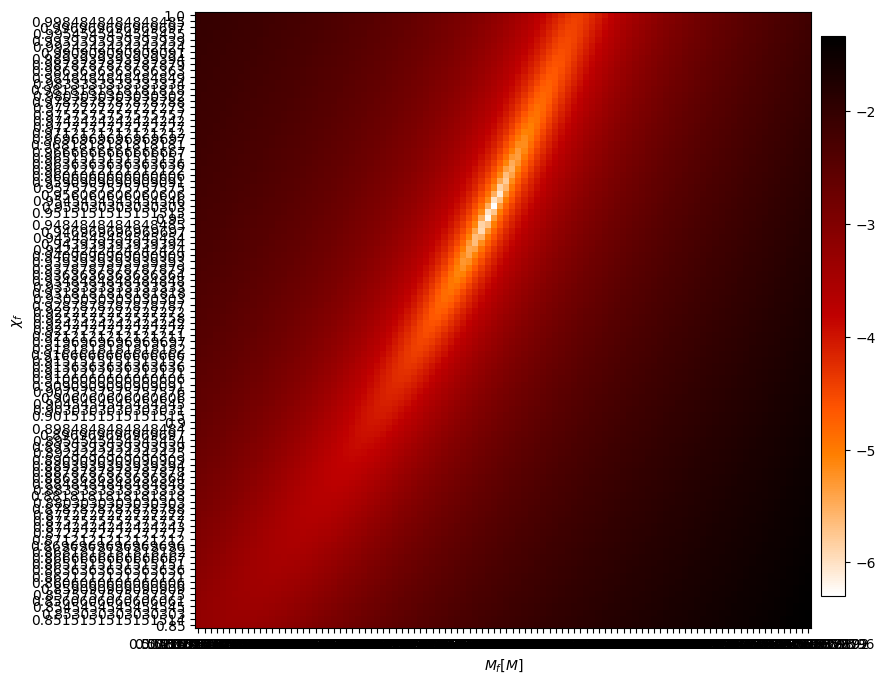

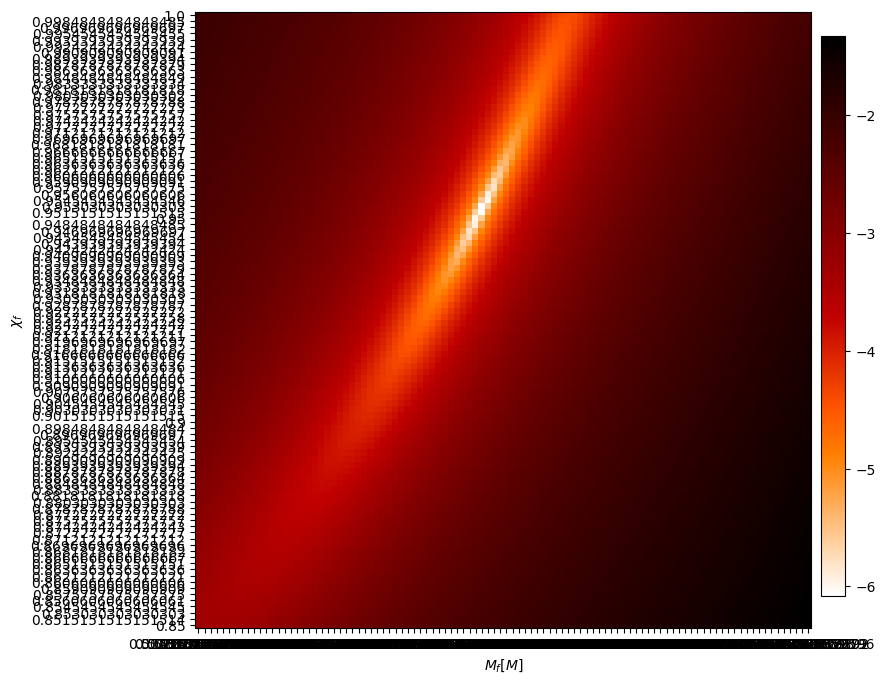

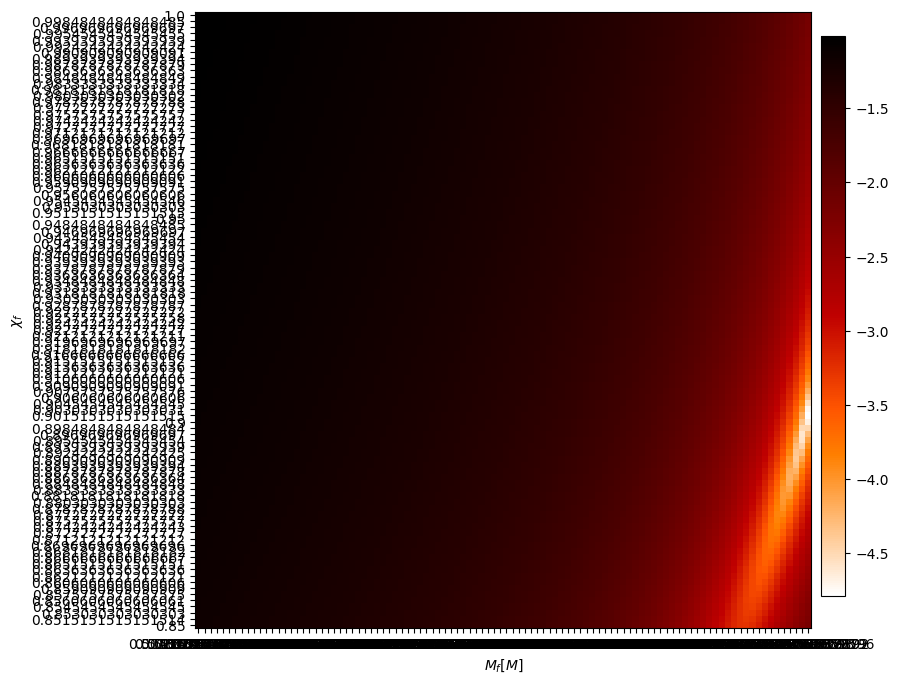

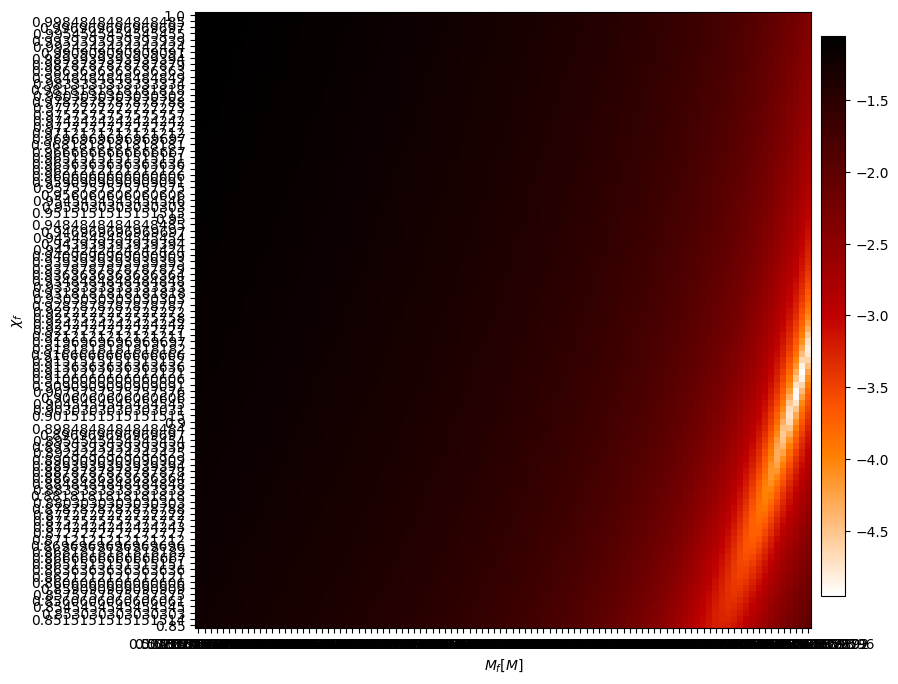

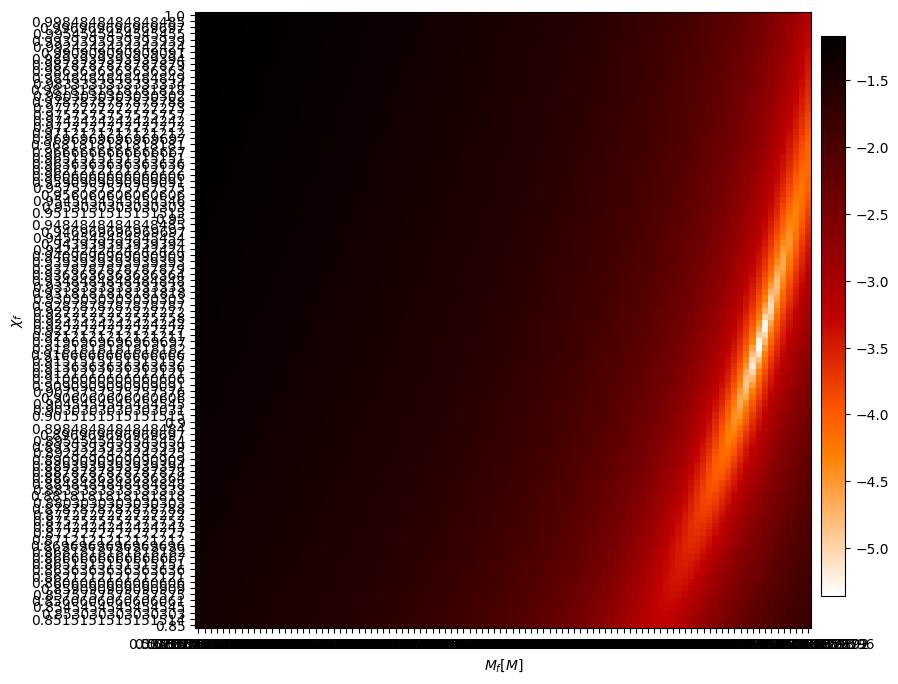

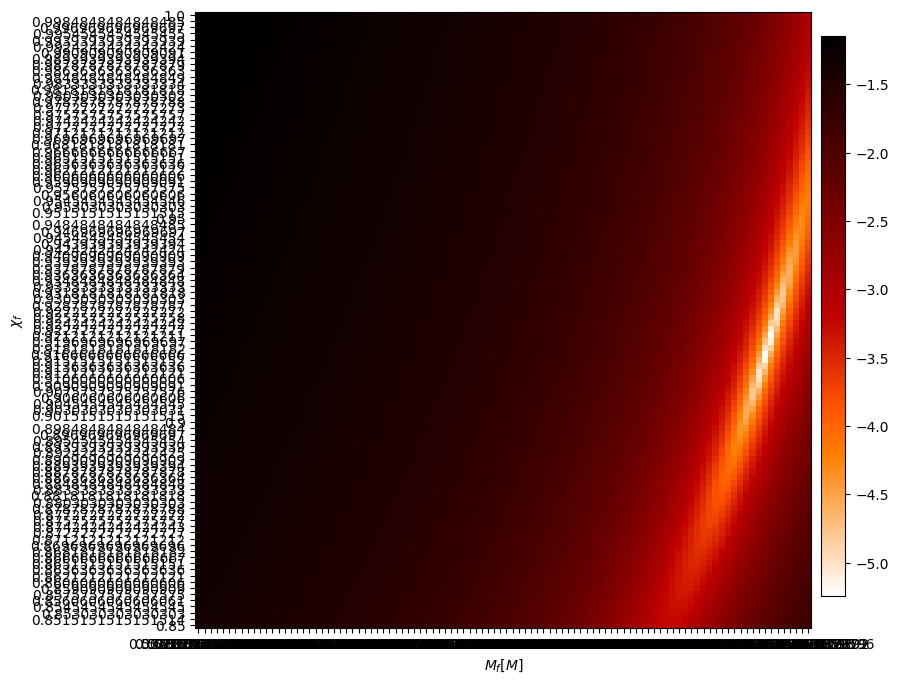

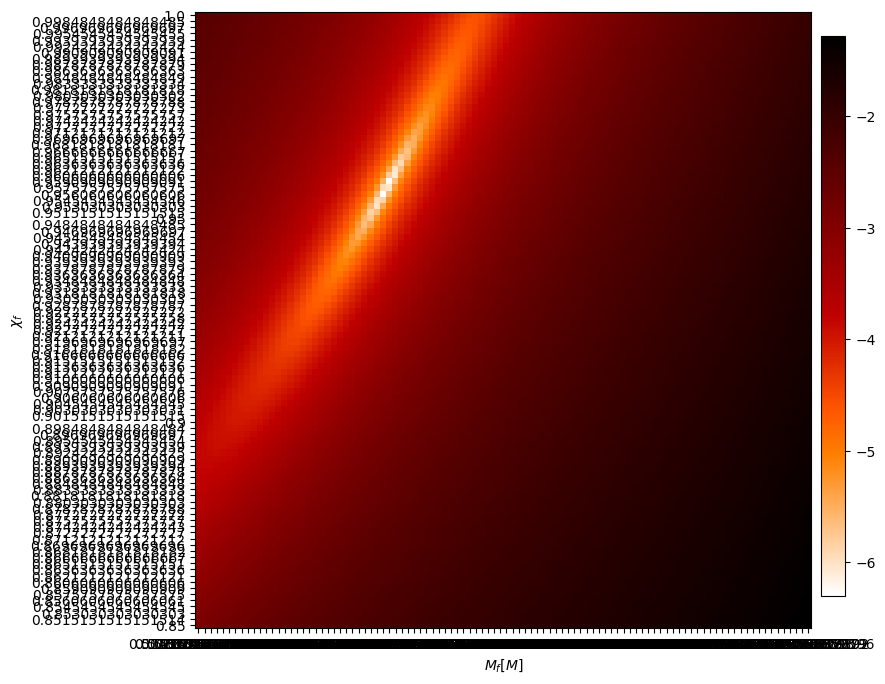

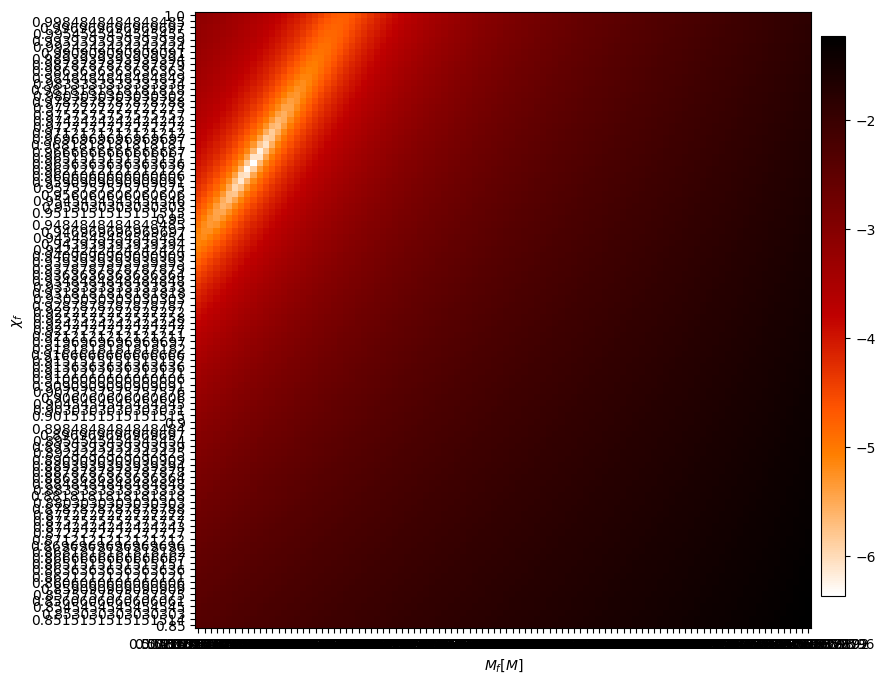

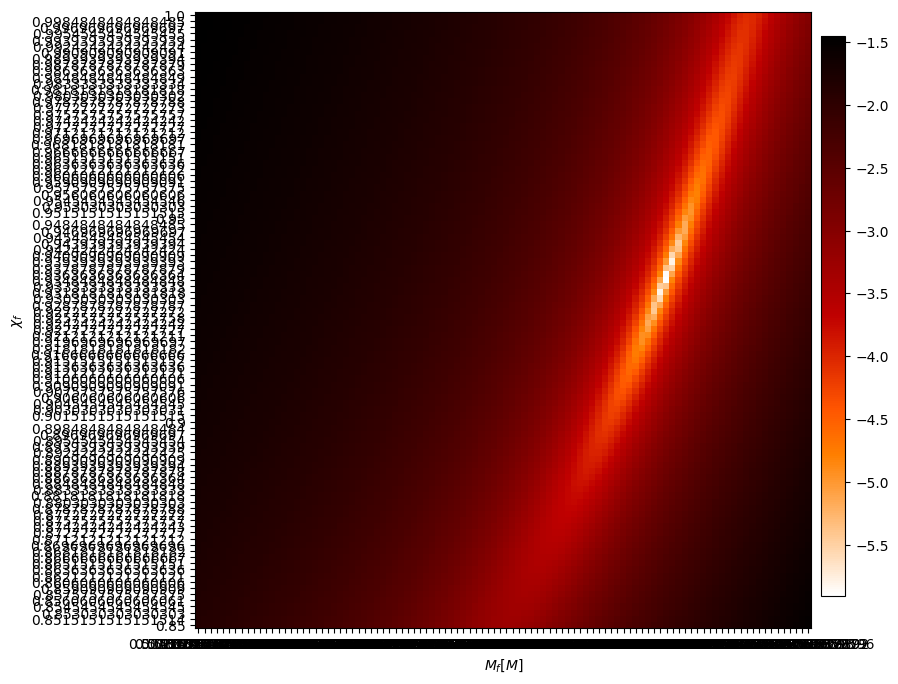

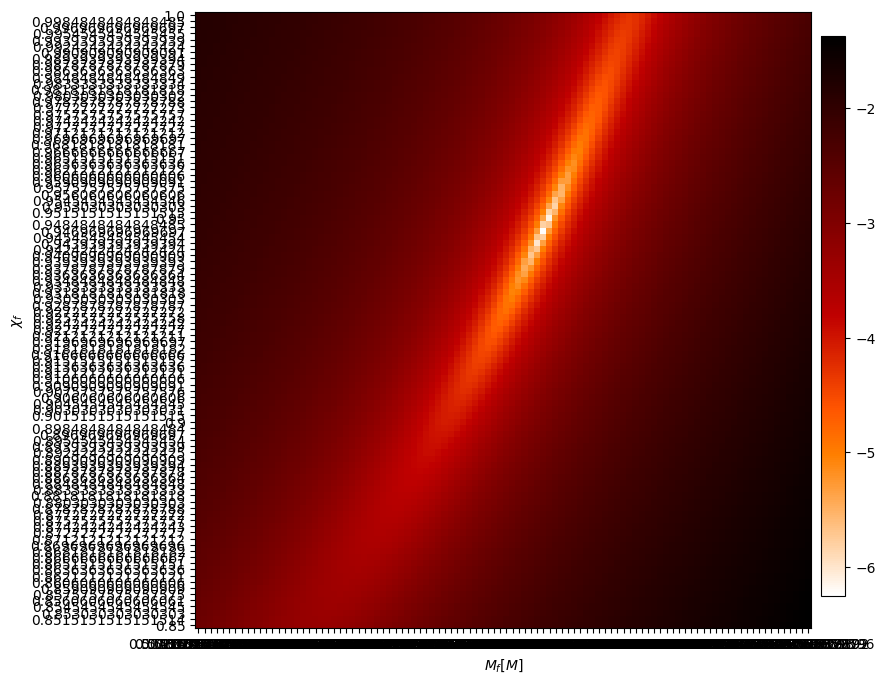

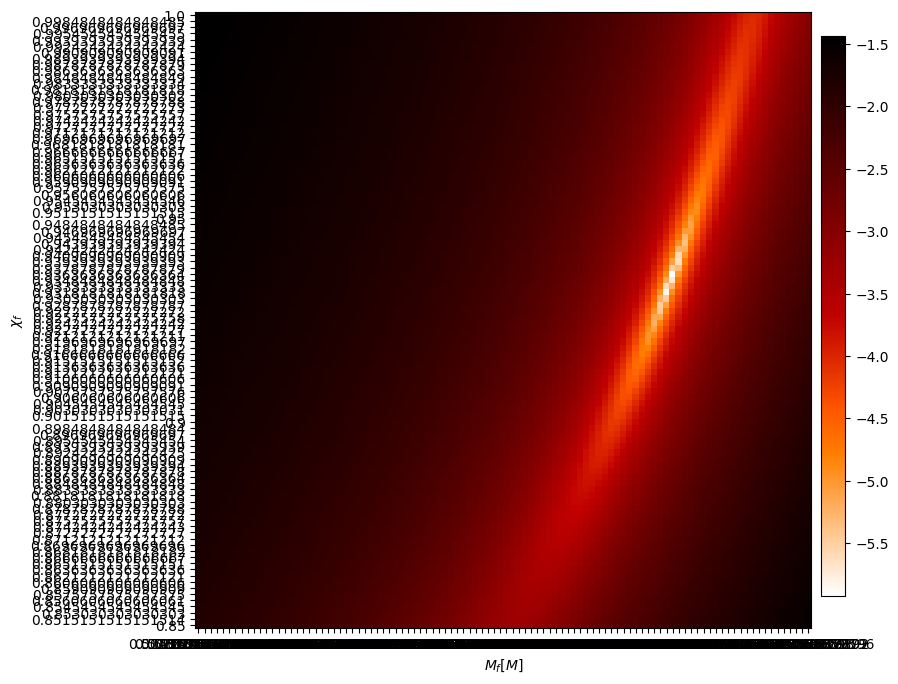

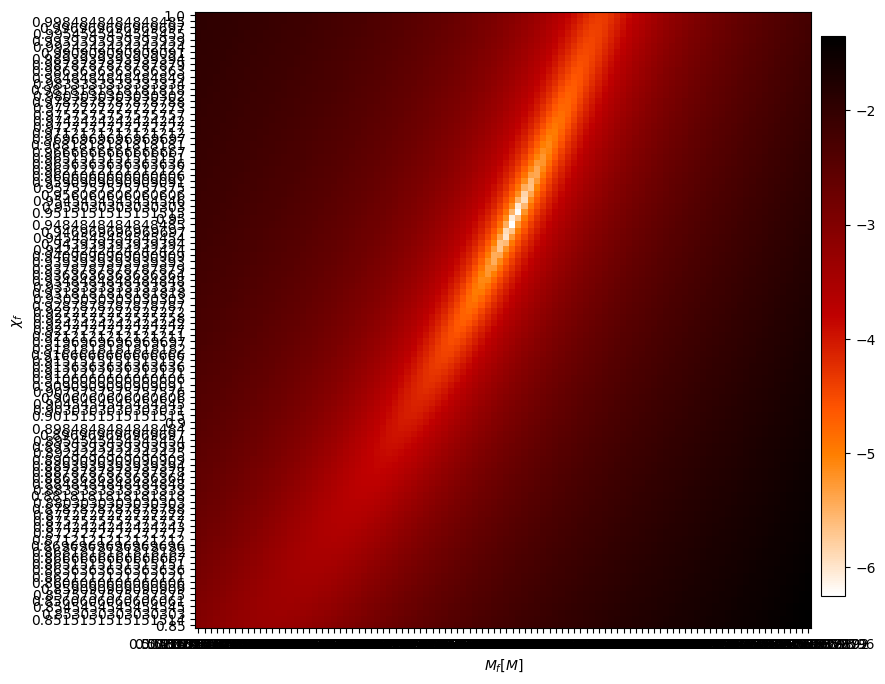

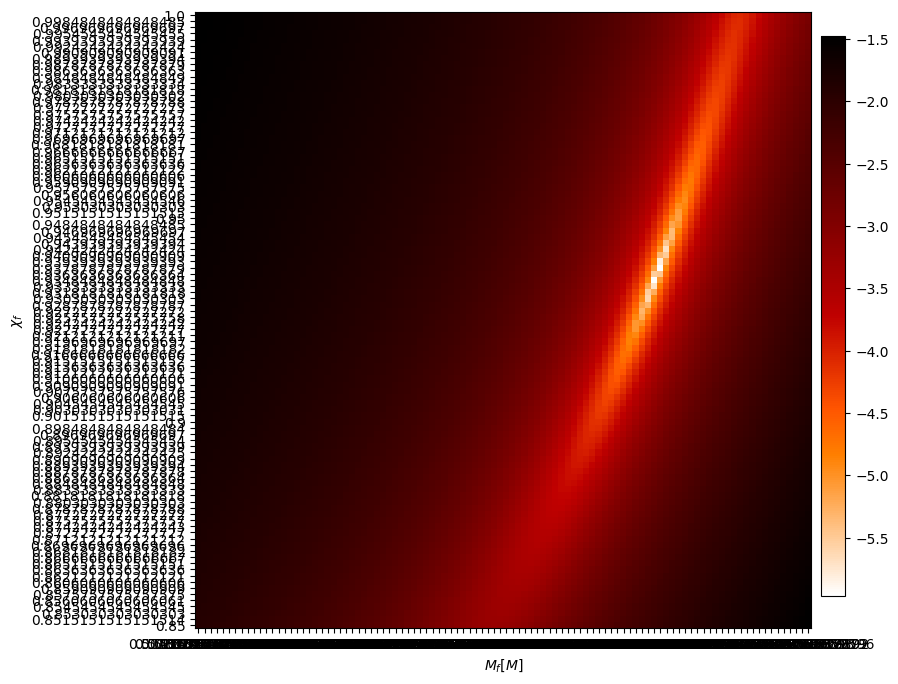

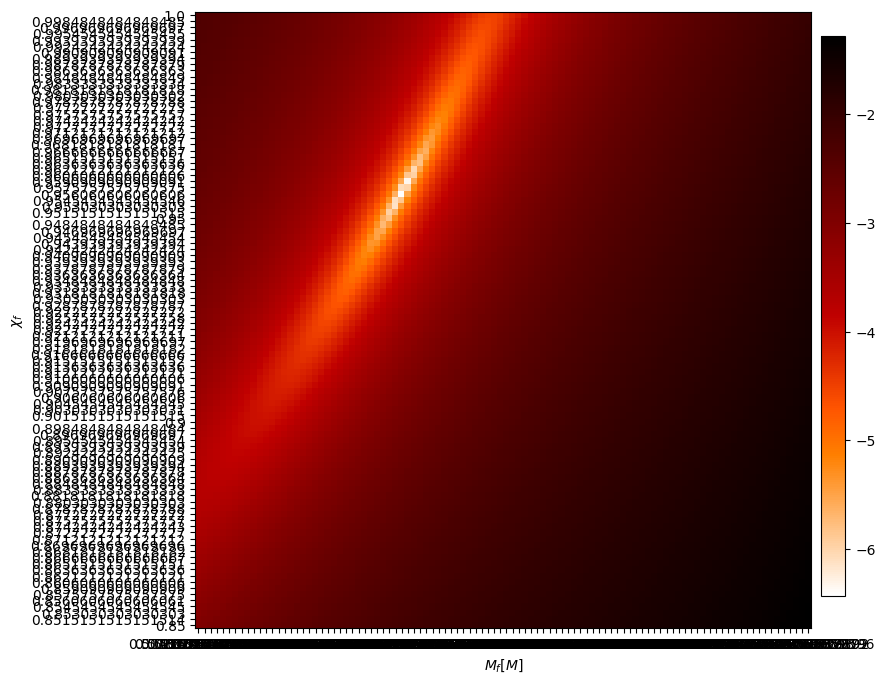

In [2]:
comb = []
for (sim,ind) in zip(sims,ids):
    fig, ax = plt.subplots(figsize=(8,8))
    
    k = 7
    
    N = 100
    x = np.linspace(0.5,0.9,num=N)
    y = np.linspace(0.85,1,num=N)
    
    Ms = []

    for j in y:
        Mss = []
        for i in x:
            modes = [(2,2,n,1) for n in range(k)]
            fit = qnmfits.ringdown_fit(
                sim.times,
                sim.h[2,2],
                modes,
                Mf=j,
                chif=i,
                t0=0,
                t0_method = 'closest'
            )
            Mss.append(fit['mismatch'])
        Ms.append(Mss)
            

    logMs = np.log(Ms)/np.log(10)
    im = ax.imshow(logMs, cmap='gist_heat_r', interpolation='none', origin='lower')


    # Creating the colorbar with explicit size
    cbar_ax = fig.add_axes([0.91, 0.15, 0.03, 0.7])  # Adjust the position and size as needed
    cbar = plt.colorbar(im, cax=cbar_ax)



    # Reassigning x-axis and y-axis labels
    # Example labels for x and y axes
    x_labels = np.linspace(0.5, 0.9, num=len(logMs[0]))
    y_labels = np.linspace(0.85, 1, num=len(logMs))

    # Set the tick locations and labels for the x-axis
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)

    # Set the tick locations and labels for the y-axis
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)



    # Set x and y axis labels
    ax.set_xlabel(r'$M_f[M]$')
    ax.set_ylabel(r'$\chi_f$')


    #ax.grid(which='both')
    #ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle) SXS:BBH:' + f'{ind:04}')
    #ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
    #ax.set_ylabel('$\mathcal{M}$')
    #ax.legend(loc='lower right')
    #ax.set_yscale('log')

    #ax.set_xlim(-11,-8)
    #ax.set_ylim(-7,-6)

    #_ = ax.legend(ncol=2, frameon=False, fontsize=7)
    #plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')
    # Save figure
    #if not os.path.exists(mismatch_dir):
    #    os.makedirs(mismatch_dir)
    #plt.savefig(mismatch_dir + 'mismatchpeakskneedle' + f'{ind:04}' + '.png', dpi=500, bbox_inches='tight')
    #print('Saved mismatchpeakskneedle' + f'{ind:04}' + '.png')
